# Load the dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("llm-council/emotional_application", "response_judging")
df = dataset["council"].to_pandas()

Generating council split: 100%|██████████████████████████████████████████████████████████████████████████████████████| 76000/76000 [00:00<00:00, 795112.85 examples/s]

DatasetDict({
    council: Dataset({
        features: ['emobench_id', 'llm_judge', 'judging_response_string', 'first_completion_by', 'second_completion_by', 'pairwise_choice'],
        num_rows: 76000
    })
})


In [5]:
df

,emobench_id,llm_judge,judging_response_string,first_completion_by,second_completion_by,pairwise_choice
0,100,command-r-plus,Explanation: Both responses demonstrate empath...,qwen1.5-32B-Chat,gpt-4o-2024-05-13,B>A
1,102,command-r-plus,Explanation: Both responses exhibit authentici...,claude-3-sonnet,qwen1.5-32B-Chat,B>A
2,100,command-r-plus,Both responses demonstrate empathy and a clear...,llama-3-70b-chat,qwen1.5-32B-Chat,A>B
3,100,command-r-plus,Both responses demonstrate empathy and offer a...,qwen1.5-32B-Chat,command-r,A>B
4,102,command-r-plus,Explanation: Both responses exhibit authentici...,qwen1.5-32B-Chat,gemini-1.0-pro,B>A
...,...,...,...,...,...,...
75995,199,gpt-4-turbo-2024-04-09,Both responses offer empathetic and actionable...,qwen1.5-32B-Chat,claude-3-haiku,A>B
75996,199,gpt-4-turbo-2024-04-09,Both responses offer thoughtful advice and dem...,gpt-3.5-turbo-0125,qwen1.5-32B-Chat,B>A
75997,199,gpt-4-turbo-2024-04-09,Both responses provide thoughtful and empathet...,qwen1.5-32B-Chat,gpt-4o-2024-05-13,A>B
75998,199,gpt-4-turbo-2024-04-09,Both responses offer thoughtful and empathetic...,qwen1.5-32B-Chat,gpt-4-turbo-2024-04-09,A>B


# Constants

In [8]:
MAJOR_A_WIN = "A>>B"
MINOR_A_WIN = "A>B"
MINOR_B_WIN = "B>A"
MAJOR_B_WIN = "B>>A"
TIE = "A=B"

# Library functions

In [50]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def sorted_dict_of_dict(data):
    # Sort the outer dictionary keys
    sorted_outer_keys = sorted(data.keys())

    # In DSxS, completer vs. completer, the inner keys are different for each outer key because
    # each completer does not face off against itself.
    all_inner_keys = set()
    for outer_key in sorted_outer_keys:
        all_inner_keys.update(data[outer_key].keys())

    sorted_inner_keys = sorted(list(all_inner_keys))

    # Ensures that council is at the end.
    if "council" in sorted_outer_keys:
        sorted_outer_keys.remove("council")
        sorted_outer_keys.append("council")
    if "council" in sorted_inner_keys:
        sorted_inner_keys.remove("council")
        sorted_inner_keys.append("council")
    if "council (by majority vote)" in sorted_outer_keys:
        sorted_outer_keys.remove("council (by majority vote)")
        sorted_outer_keys.append("council (by majority vote)")
    if "council (by mean pooling)" in sorted_outer_keys:
        sorted_outer_keys.remove("council (by mean pooling)")
        sorted_outer_keys.append("council (by mean pooling)")
    if "council (no aggregation)" in sorted_outer_keys:
        sorted_outer_keys.remove("council (no aggregation)")
        sorted_outer_keys.append("council (no aggregation)")
    if "council (by majority vote)" in sorted_inner_keys:
        sorted_inner_keys.remove("council (by majority vote)")
        sorted_inner_keys.append("council (by majority vote)")
    if "council (by mean pooling)" in sorted_inner_keys:
        sorted_inner_keys.remove("council (by mean pooling)")
        sorted_inner_keys.append("council (by mean pooling)")
    if "council (no aggregation)" in sorted_inner_keys:
        sorted_inner_keys.remove("council (no aggregation)")
        sorted_inner_keys.append("council (no aggregation)")

    final_structure = {}
    for outer_key in sorted_outer_keys:
        # Sort the inner dictionary by the sorted outer keys for consistent ordering
        final_structure[outer_key] = {
            inner_key: data[outer_key].get(inner_key)
            for inner_key in sorted_inner_keys
        }

    return final_structure


def plot_heatmap(
    data,
    title,
    xlabel,
    ylabel,
    vmin=None,
    vmax=None,
    center=None,
    cmap="coolwarm",
    norm=None,
    figsize=None,
):
    # Convert the nested dictionary to a DataFrame
    df = pd.DataFrame(data)

    # Plotting the heatmap
    plt.figure(figsize=(20, 16) if figsize is None else figsize)
    sns.heatmap(
        df,
        annot=df,
        cmap=cmap,
        fmt=".2f",
        vmin=vmin,
        vmax=vmax,
        center=center,
        norm=norm,
    )
    plt.title(title)
    plt.setp(plt.xticks()[1], rotation=90)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()


def get_mean_pooling_choice(agg_list):
    choice_to_value_map = {
        MAJOR_A_WIN: 2,
        MINOR_A_WIN: 1,
        TIE: 0,
        MINOR_B_WIN: -1,
        MAJOR_B_WIN: -2,
    }
    value_to_choice_map = {
        2: MAJOR_A_WIN,
        1: MINOR_A_WIN,
        0: TIE,
        -1: MINOR_B_WIN,
        -2: MAJOR_B_WIN,
    }
    numeric_values = agg_list.apply(lambda x: choice_to_value_map[x])
    return value_to_choice_map[round(np.mean(numeric_values))]


def get_council_choice(df, council_aggregation_method):
    if council_aggregation_method == "majority":
        df_aggregated = (
            df.groupby(["emobench_id", "first_completion_by", "second_completion_by"])
            .agg(
                pairwise_choice=pd.NamedAgg(
                    column="pairwise_choice", aggfunc=lambda x: x.mode()[0]
                )
            )
            .reset_index()
        )
        return df_aggregated
    if council_aggregation_method == "mean_pooling":
        # Council, by mean pooling.
        df_aggregated = (
            df.groupby(["emobench_id", "first_completion_by", "second_completion_by"])
            .agg(
                pairwise_choice=pd.NamedAgg(
                    column="pairwise_choice", aggfunc=get_mean_pooling_choice
                )
            )
            .reset_index()
        )
        return df_aggregated
    raise ValueError(
        f"Invalid council aggregation method: {council_aggregation_method}"
    )

# Vote filtering functions

- For oligarchal councils, use `filter_ratings_by_allowlist` to first filter out all votes for excluded council members.
- For consistent vote analysis, use `df = get_consistent_votes(df)` to first filter out all inconsistent votes.

In [65]:
def get_consistent_votes(df):
    """Function for getting consistent votes."""
    judges = list(df["llm_judge"].unique())

    judge_to_votes_map = defaultdict(dict)
    for i, row in df.iterrows():
        judge_to_votes_map[row["llm_judge"]][
            (
                row["emobench_id"],
                row["first_completion_by"],
                row["second_completion_by"],
            )
        ] = row

    # LLM judge -> emobench_id -> pairwise_choice
    consistent_votes = []
    for judge, votes in judge_to_votes_map.items():
        vote_keys = votes.keys()

        for vote_key in vote_keys:
            (emobench_id, first_completion_by, second_completion_by) = vote_key
            pairwise_choice = votes[vote_key]["pairwise_choice"]
            try:
                reverse_choice = votes[(emobench_id, second_completion_by, first_completion_by)][
                    "pairwise_choice"
                ]
            except Exception as e:
                breakpoint()

            # Count consistencies and inconsistencies.
            if (
                (pairwise_choice == MINOR_A_WIN and reverse_choice == MINOR_B_WIN)
                or (pairwise_choice == MAJOR_A_WIN and reverse_choice == MAJOR_B_WIN)
                or (pairwise_choice == MAJOR_A_WIN and reverse_choice == MINOR_B_WIN)
                or (pairwise_choice == MINOR_A_WIN and reverse_choice == MAJOR_B_WIN)
                or (pairwise_choice == MINOR_B_WIN and reverse_choice == MINOR_A_WIN)
                or (pairwise_choice == MINOR_B_WIN and reverse_choice == MAJOR_A_WIN)
                or (pairwise_choice == MAJOR_B_WIN and reverse_choice == MINOR_A_WIN)
                or (pairwise_choice == MAJOR_B_WIN and reverse_choice == MAJOR_A_WIN)
                or (pairwise_choice == TIE and reverse_choice == TIE)
            ):
                consistent_votes.append(
                    {
                        "emobench_id": emobench_id,
                        "first_completion_by": first_completion_by,
                        "second_completion_by": second_completion_by,
                        "pairwise_choice": pairwise_choice,
                        "llm_judge": judge,
                    }
                )

    return pd.DataFrame(consistent_votes)


def filter_ratings_by_allowlist(df, llm_judge_allowlist):
    return df[df["llm_judge"].isin(llm_judge_allowlist)]

# Terry-Bradley Analysis

In [11]:
import numpy as np
import choix
from collections import defaultdict

In [12]:
def get_choix_data(df):
    """Returns a dataframe in the format that the choix library expects it."""
    subjects = np.unique(df[["first_completion_by", "second_completion_by"]])
    n_items = len(subjects)
    council_member_map = {subjects[i]: i for i in range(n_items)}

    data = []
    for i, row in df.iterrows():
        if row["pairwise_choice"] == MAJOR_A_WIN:
            data.append(
                (
                    council_member_map[row["first_completion_by"]],
                    council_member_map[row["second_completion_by"]],
                )
            )
            data.append(
                (
                    council_member_map[row["first_completion_by"]],
                    council_member_map[row["second_completion_by"]],
                )
            )
        if row["pairwise_choice"] == MINOR_A_WIN:
            data.append(
                (
                    council_member_map[row["first_completion_by"]],
                    council_member_map[row["second_completion_by"]],
                )
            )
        if row["pairwise_choice"] == MAJOR_B_WIN:
            data.append(
                (
                    council_member_map[row["second_completion_by"]],
                    council_member_map[row["first_completion_by"]],
                )
            )
            data.append(
                (
                    council_member_map[row["second_completion_by"]],
                    council_member_map[row["first_completion_by"]],
                )
            )
        if row["pairwise_choice"] == MINOR_B_WIN:
            data.append(
                (
                    council_member_map[row["second_completion_by"]],
                    council_member_map[row["first_completion_by"]],
                )
            )
    return data

In [13]:
subjects = np.unique(df[["first_completion_by", "second_completion_by"]])
n_items = len(subjects)
council_member_map = {subjects[i]: i for i in range(n_items)}

data = get_choix_data(df)
params = choix.ilsr_pairwise(n_items, data)

# Prep the expected win rate map for the heatmap.
expected_win_rate_map = defaultdict(dict)
for council_member_1 in subjects:
    for council_member_2 in subjects:
        prob_1_wins, prob_2_wins = choix.probabilities(
            [
                council_member_map[council_member_1],
                council_member_map[council_member_2],
            ],
            params,
        )
        # We reverse the order to ensure the heatmap rendering can be read from left to right.
        expected_win_rate_map[council_member_2][council_member_1] = prob_1_wins
        expected_win_rate_map[council_member_1][council_member_2] = prob_2_wins

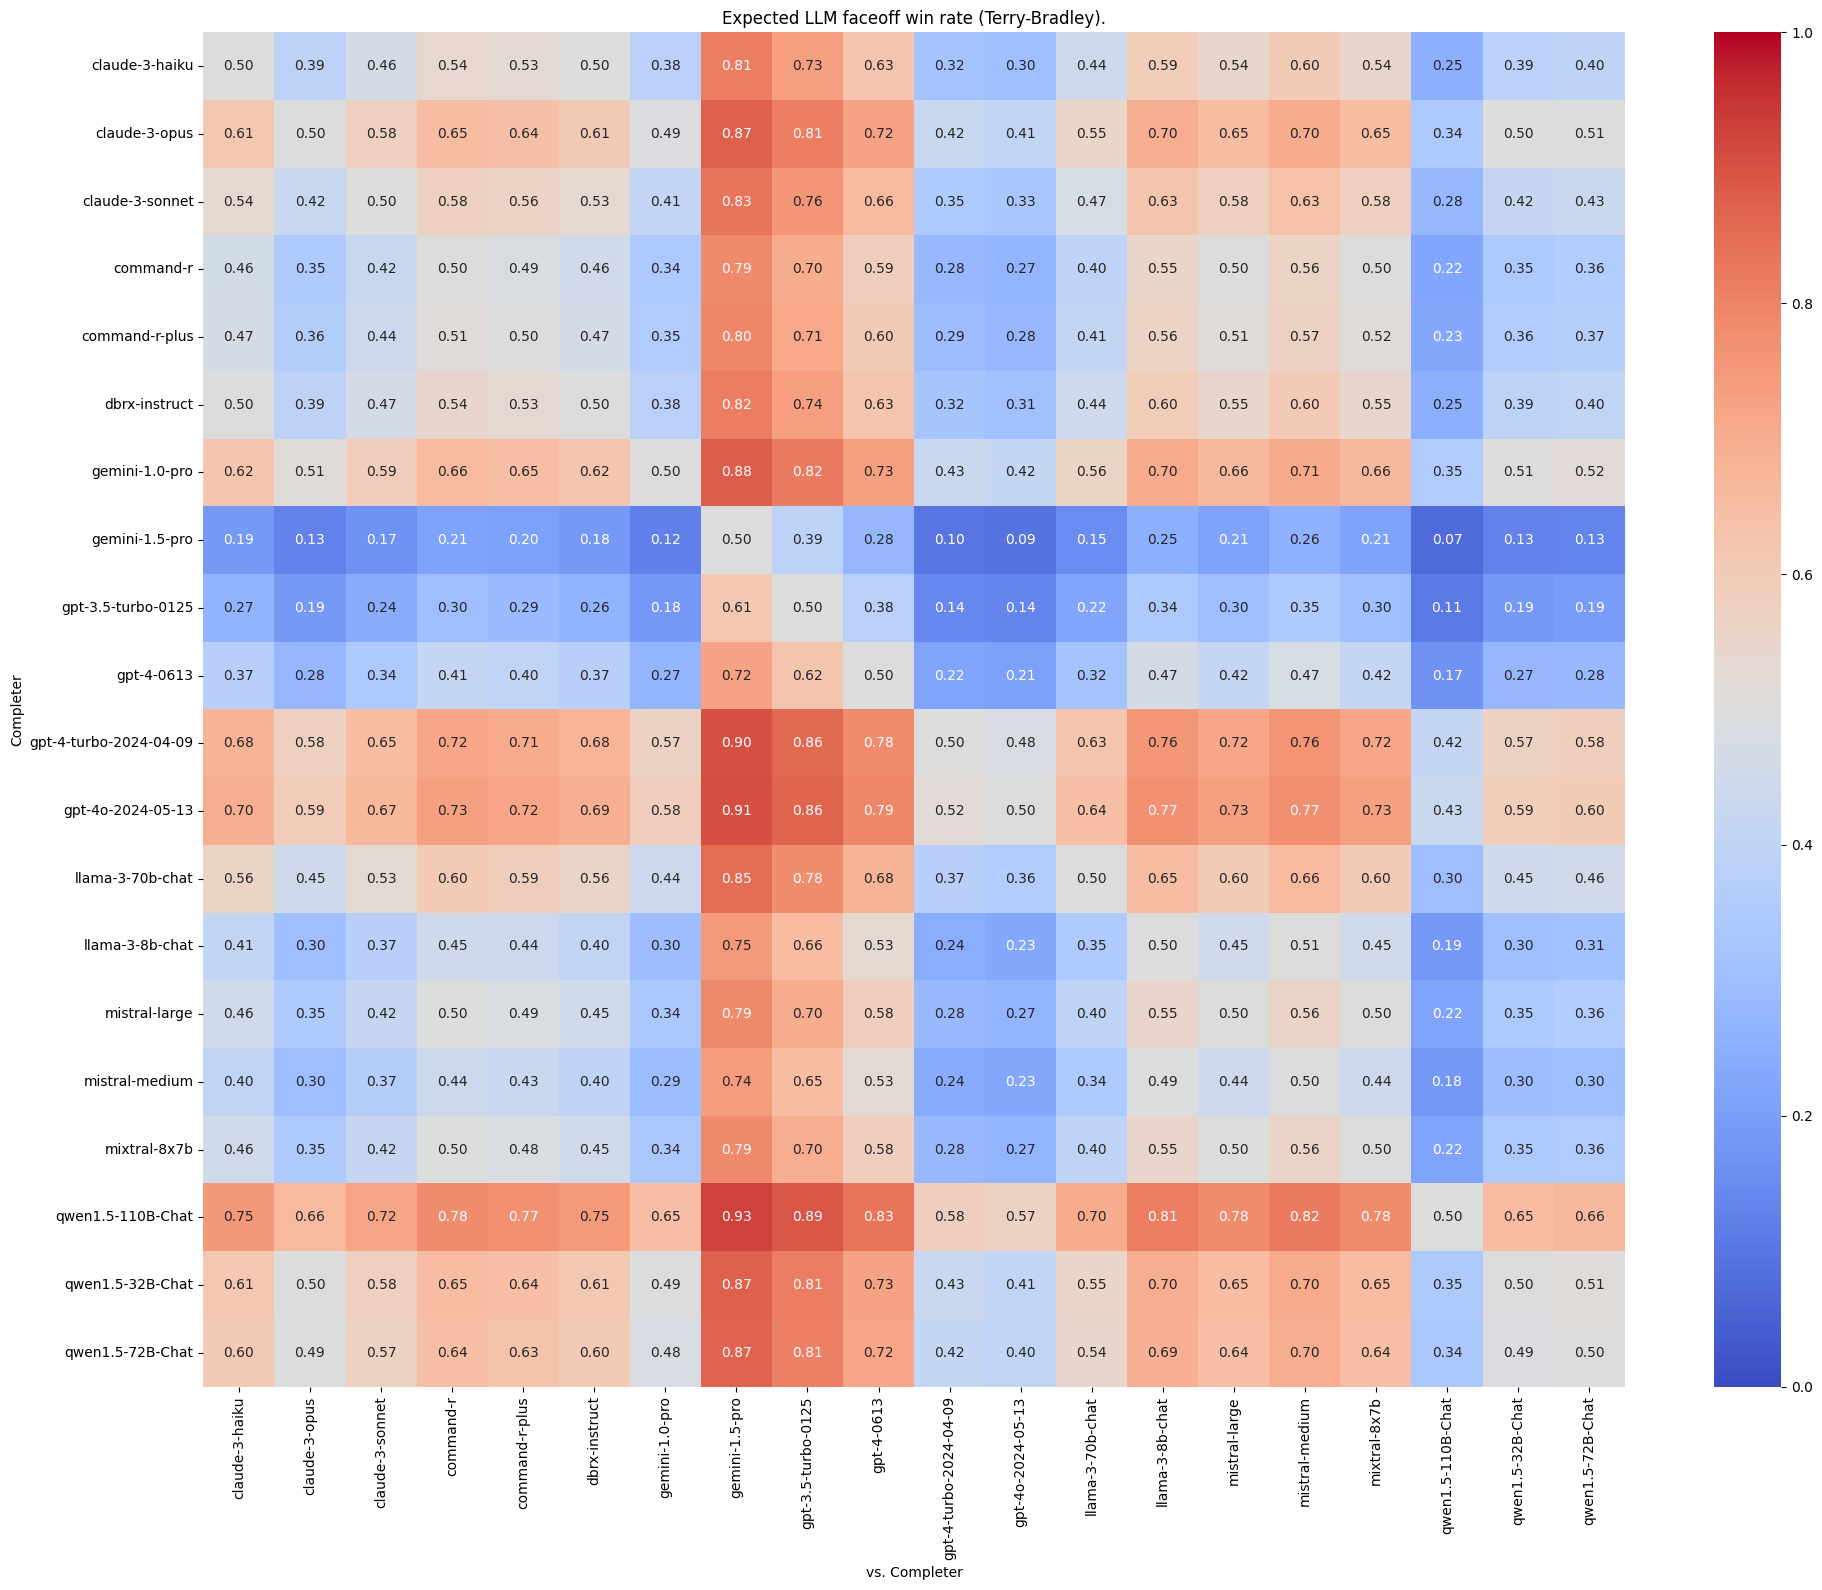

In [28]:
plot_heatmap(
    expected_win_rate_map,
    "Expected LLM faceoff win rate (Terry-Bradley).",
    ylabel="Completer",
    xlabel="vs. Completer",
    vmin=0,
    vmax=1,
    cmap="coolwarm",
)

# Separability Analysis

## Helper functions

In [56]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import math
from itertools import combinations


def predict_win_rate(elo_ratings, SCALE=400, BASE=10, INIT_RATING=1000):
    names = sorted(list(elo_ratings.keys()))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (1 + BASE ** ((elo_ratings[b] - elo_ratings[a]) / SCALE))
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T


def get_win_rate_column(df, column, baseline):
    to_dict = df[["model", column]].set_index("model").to_dict()[column]
    win_rate_table = predict_win_rate(to_dict)
    return win_rate_table[baseline].fillna(0.5).apply(lambda x: round(x * 100, 2))


def get_win_rate(bootstrap_online_elo, reference_llm_completer):
    stats = pd.DataFrame()
    stats["results"] = None
    stats["results"] = stats["results"].astype("object")

    for i, model in enumerate(bootstrap_online_elo.index):
        stats.at[i, "model"] = model
        stats.at[i, "score"] = bootstrap_online_elo[model]

    return get_win_rate_column(stats, "score", reference_llm_completer)


# Simplified from https://github.com/lm-sys/arena-hard-auto/blob/main/show_result.py#L112C1-L176C30
def get_battles_from_judgment(df, WEIGHT=3):
    battles = []
    for _, row in df.iterrows():
        output = {
            "question_id": row["emobench_id"],
            "model_a": row["first_completion_by"],
            "model_b": row["second_completion_by"],
        }

        weight = 1
        if row["pairwise_choice"] == "A=B":
            output["winner"] = "tie"
        elif row["pairwise_choice"] == "A>B":
            output["winner"] = "model_a"
        elif row["pairwise_choice"] == "A>>B":
            output["winner"] = "model_a"
            weight = WEIGHT
        elif row["pairwise_choice"] == "B>A":
            output["winner"] = "model_b"
        elif row["pairwise_choice"] == "B>>A":
            output["winner"] = "model_b"
            weight = WEIGHT

        for i in range(weight):
            battles.append(output)

    return pd.DataFrame(battles)


# Adapted from Arena Hard: https://github.com/lm-sys/arena-hard-auto/blob/main/show_result.py#L18
def compute_mle_elo(df, reference_llm_completer, SCALE=400, BASE=10, INIT_RATING=1000):
    df = get_battles_from_judgment(df)

    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "model_a"] = 1.0
    # Y[df["winner"] == "A>B"] = 1.0

    # one tie => one A win + one B win
    # Counts 1 tie as 1 A win and 1 B win, which is why we duplicate the battles.
    # tie_idx = df["winner"] == "A=B"
    tie_idx = df["winner"] == "tie"
    tie_idx[len(tie_idx) // 2 :] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-8)
    lr.fit(X, Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as reference_llm_completer = 1000
    if reference_llm_completer in models.index:
        elo_scores += 1000 - elo_scores[models[reference_llm_completer]]
    return pd.Series(elo_scores, index=models.index).sort_values(ascending=False)


# Adapted from https://github.com/lm-sys/arena-hard-auto/blob/main/show_result.py#L52
def get_bootstrap_result(
    df,
    func_compute_elo,
    num_round,
    reference_llm_completer,
):
    battles = get_battles_from_judgment(df)

    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(
            func_compute_elo(
                # Bootstrapping.
                df.sample(n=len(df), replace=True),
                reference_llm_completer,
            )
        )
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


# Adapted from https://github.com/lm-sys/arena-hard-auto/blob/main/show_result.py#L218-L254.
def get_stats_for_bootstrap(
    bootstrap_online_elo, bootstrap_elo_lu, reference_llm_completer
):
    stats = pd.DataFrame()
    stats["results"] = None
    stats["results"] = stats["results"].astype("object")

    for i, model in enumerate(bootstrap_online_elo.index):
        assert model in bootstrap_elo_lu.columns

        stats.at[i, "model"] = model
        stats.at[i, "score"] = bootstrap_online_elo[model]
        stats.at[i, "lower"] = np.percentile(bootstrap_elo_lu[model], 2.5)
        stats.at[i, "upper"] = np.percentile(bootstrap_elo_lu[model], 97.5)
        stats.at[i, "results"] = bootstrap_elo_lu[model].tolist()

    stats.sort_values(by="model", inplace=True)
    stats["score"] = get_win_rate_column(
        stats, "score", reference_llm_completer
    ).tolist()
    stats["lower"] = get_win_rate_column(
        stats, "lower", reference_llm_completer
    ).tolist()
    stats["upper"] = get_win_rate_column(
        stats, "upper", reference_llm_completer
    ).tolist()
    decimal = 1

    stats = stats.sort_values(by="score", ascending=False)
    stats["lower_ci"] = (stats["lower"] - stats["score"]).round(decimal)
    stats["upper_ci"] = (stats["upper"] - stats["score"]).round(decimal)
    stats["score_with_ci_str"] = (
        stats["score"].astype(str)
        + " ("
        + stats["lower_ci"].astype(str)
        + ", "
        + stats["upper_ci"].astype(str)
        + ")"
    )
    for _, row in stats.iterrows():
        interval = str(
            (
                round(row["lower"] - row["score"], decimal),
                round(row["upper"] - row["score"], decimal),
            )
        )
        print(
            f"{row['model'] : <30} | score: {round(row['score'], decimal) : ^5} | 95% CI: {interval : ^12}"
        )
    return stats


def calculate_non_overlapping_percentage(
    df, model_column_name="model", lower_column_name="lower", upper_column_name="upper"
):
    # Extract the model names and intervals
    models = df[model_column_name]
    intervals = df[[lower_column_name, upper_column_name]]

    # Calculate all possible pairs of models
    total_pairs = 0
    non_overlapping_pairs = 0

    for (model1, interval1), (model2, interval2) in combinations(
        zip(models, intervals.itertuples(index=False, name=None)), 2
    ):
        total_pairs += 1
        lower1, upper1 = interval1
        lower2, upper2 = interval2

        # Check if intervals do not overlap
        if upper1 < lower2 or upper2 < lower1:
            non_overlapping_pairs += 1

    # Calculate the percentage of non-overlapping pairs
    if total_pairs > 0:
        percentage = (non_overlapping_pairs / total_pairs) * 100
    else:
        percentage = 0  # In case there are not enough models to form a pair

    return percentage

## Separability analysis

In [84]:
reference_llm_completer = "qwen1.5-32B-Chat"
bootstrap_rounds = 5
# bootstrap_rounds = 100  # Use this for full results.
council_member_to_separability = {}
judge_polarization = {}
council_member_to_rankings = {}

# Council, without aggregation.
bootstrap_online_elo = compute_mle_elo(df, reference_llm_completer)
bootstrap_elo_lu = get_bootstrap_result(
    df,
    compute_mle_elo,
    bootstrap_rounds,
    reference_llm_completer,
)
print("Expected win rates for full council, without aggregation.")
stats = get_stats_for_bootstrap(
    bootstrap_online_elo, bootstrap_elo_lu, reference_llm_completer
)
council_member_to_rankings["council (no agg)"] = stats

percentage_non_overlapping = calculate_non_overlapping_percentage(stats)
council_member_to_separability["council (no agg)"] = percentage_non_overlapping
judge_polarization["council (no agg)"] = stats["score"].max() - stats["score"].min()

# Council, with aggregation.
council_choice = get_council_choice(df, "majority")
bootstrap_online_elo = compute_mle_elo(council_choice, reference_llm_completer)
bootstrap_elo_lu = get_bootstrap_result(
    council_choice,
    compute_mle_elo,
    bootstrap_rounds,
    reference_llm_completer,
)
print("Expected win rates for full council, by majority vote.")
stats = get_stats_for_bootstrap(
    bootstrap_online_elo, bootstrap_elo_lu, reference_llm_completer
)
council_member_to_rankings["council (by majority vote)"] = stats
judge_polarization["council (by majority vote)"] = (
    stats["score"].max() - stats["score"].min()
)
percentage_non_overlapping = calculate_non_overlapping_percentage(stats)
council_member_to_separability["council (by majority vote)"] = (
    percentage_non_overlapping
)

# Council, with mean pooling aggregation.
council_choice = get_council_choice(df, "mean_pooling")
bootstrap_online_elo = compute_mle_elo(council_choice, reference_llm_completer)
bootstrap_elo_lu = get_bootstrap_result(
    council_choice,
    compute_mle_elo,
    bootstrap_rounds,
    reference_llm_completer,
)
print("Expected win rates for full council, by mean pooling.")
stats = get_stats_for_bootstrap(
    bootstrap_online_elo, bootstrap_elo_lu, reference_llm_completer
)
council_member_to_rankings["council (by mean pooling)"] = stats
judge_polarization["council (by mean pooling)"] = (
    stats["score"].max() - stats["score"].min()
)
percentage_non_overlapping = calculate_non_overlapping_percentage(stats)
council_member_to_separability["council (by mean pooling)"] = (
    percentage_non_overlapping
)

# Individual council members.
council_members = list(df["llm_judge"].unique())
for council_member in council_members:
    filtered_df = filter_ratings_by_allowlist(df, [council_member])
    bootstrap_online_elo = compute_mle_elo(filtered_df, reference_llm_completer)
    bootstrap_elo_lu = get_bootstrap_result(
        filtered_df,
        compute_mle_elo,
        bootstrap_rounds,
        reference_llm_completer,
    )

    # Outputs
    print(f"Expected win rates for {council_member}.")
    stats = get_stats_for_bootstrap(
        bootstrap_online_elo, bootstrap_elo_lu, reference_llm_completer
    )
    judge_polarization[council_member] = stats["score"].max() - stats["score"].min()
    council_member_to_separability[council_member] = (
        calculate_non_overlapping_percentage(stats)
    )
    council_member_to_rankings[council_member] = stats

# Save polarization.
judge_polarization_df = pd.DataFrame(judge_polarization, index=["polarization"])

# Separability overall.
# Plot separability
council_member_to_separability_df = pd.DataFrame([council_member_to_separability]).T
council_member_to_separability_df.columns = ["separability"]
council_member_to_separability_df = council_member_to_separability_df.rename(
    index=LLM_TO_PLOT_FRIENDLY_NAME
)

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


Expected win rates for full council, without aggregation.
qwen1.5-110B-Chat              | score: 65.7  | 95% CI: (-0.7, 0.3) 
gpt-4o-2024-05-13              | score: 59.1  | 95% CI: (-0.6, 0.7) 
gpt-4-turbo-2024-04-09         | score: 57.6  | 95% CI: (-0.9, 0.3) 
gemini-1.0-pro                 | score: 50.6  | 95% CI: (-0.2, 0.2) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 49.9  | 95% CI: (-1.4, 0.5) 
qwen1.5-72B-Chat               | score: 48.5  | 95% CI: (-1.3, 1.7) 
llama-3-70b-chat               | score: 44.9  | 95% CI: (-0.7, 1.2) 
claude-3-sonnet                | score: 42.4  | 95% CI: (-2.0, -0.1)
dbrx-instruct                  | score: 38.7  | 95% CI: (-1.2, 0.7) 
claude-3-haiku                 | score: 38.4  | 95% CI: (-0.4, 1.1) 
command-r-plus                 | score: 35.5  | 95% CI: (-1.0, 0.4) 
command-r                      | score: 34.4  | 95% CI: (-0.8, 0.9) 
mixtral-8x7b                   | score: 34.2 

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s]


Expected win rates for full council, by majority vote.
qwen1.5-110B-Chat              | score: 77.5  | 95% CI: (-1.3, 4.1) 
gpt-4o-2024-05-13              | score: 68.5  | 95% CI: (-1.5, 4.0) 
gpt-4-turbo-2024-04-09         | score: 64.5  | 95% CI: (-4.7, 5.0) 
gemini-1.0-pro                 | score: 52.5  | 95% CI: (-6.4, 5.7) 
qwen1.5-72B-Chat               | score: 51.0  | 95% CI: (-2.0, 3.5) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 46.5  | 95% CI: (-4.3, 1.7) 
llama-3-70b-chat               | score: 35.5  | 95% CI: (-6.0, 3.7) 
claude-3-sonnet                | score: 30.0  | 95% CI: (-4.1, 0.8) 
claude-3-haiku                 | score: 28.0  | 95% CI: (-4.8, 3.2) 
dbrx-instruct                  | score: 27.0  | 95% CI:  (0.8, 5.9) 
command-r-plus                 | score: 25.0  | 95% CI: (-1.6, 0.9) 
mistral-large                  | score: 25.0  | 95% CI: (-4.1, 3.3) 
command-r                      | score: 21.0  | 

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


Expected win rates for full council, by mean pooling.
qwen1.5-110B-Chat              | score: 65.8  | 95% CI: (-3.0, 3.5) 
gpt-4-turbo-2024-04-09         | score: 58.8  | 95% CI: (-1.0, 2.8) 
gpt-4o-2024-05-13              | score: 58.0  | 95% CI: (-1.2, 1.2) 
claude-3-opus                  | score: 51.5  | 95% CI: (-2.0, 2.3) 
gemini-1.0-pro                 | score: 51.0  | 95% CI: (-0.7, 2.1) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 49.2  | 95% CI: (-1.7, 1.4) 
llama-3-70b-chat               | score: 46.5  | 95% CI: (-1.3, 0.8) 
claude-3-sonnet                | score: 42.5  | 95% CI: (-1.3, 1.5) 
dbrx-instruct                  | score: 40.5  | 95% CI: (-4.9, 1.5) 
claude-3-haiku                 | score: 36.8  | 95% CI: (-6.0, 1.4) 
command-r-plus                 | score: 35.5  | 95% CI: (-3.5, -0.3)
mistral-large                  | score: 34.5  | 95% CI: (-1.0, 1.3) 
command-r                      | score: 34.0  | 9

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s]


Expected win rates for command-r-plus.
qwen1.5-110B-Chat              | score: 64.8  | 95% CI: (-1.8, 4.6) 
gpt-4o-2024-05-13              | score: 59.9  | 95% CI: (-4.5, 4.6) 
gpt-4-turbo-2024-04-09         | score: 56.9  | 95% CI: (-9.8, 2.8) 
qwen1.5-72B-Chat               | score: 51.8  | 95% CI: (-3.9, 2.8) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 48.5  | 95% CI: (-3.5, 4.7) 
gemini-1.0-pro                 | score: 47.6  | 95% CI: (-1.8, 10.2)
llama-3-70b-chat               | score: 43.6  | 95% CI: (-2.8, 3.2) 
claude-3-haiku                 | score: 42.6  | 95% CI: (-1.4, 12.2)
command-r-plus                 | score: 42.1  | 95% CI: (-2.6, 5.0) 
claude-3-sonnet                | score: 41.1  | 95% CI: (-4.6, -0.4)
command-r                      | score: 37.2  | 95% CI: (-8.3, -1.4)
dbrx-instruct                  | score: 35.4  | 95% CI: (-3.2, 5.2) 
mixtral-8x7b                   | score: 34.2  | 95% CI: (-4.4, 4

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Expected win rates for command-r.
qwen1.5-110B-Chat              | score: 53.0  | 95% CI: (-3.7, 6.5) 
gpt-4-turbo-2024-04-09         | score: 51.4  | 95% CI: (-5.4, 1.3) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 48.5  | 95% CI: (-9.2, 7.6) 
gemini-1.0-pro                 | score: 47.2  | 95% CI: (-8.0, 3.9) 
gpt-4o-2024-05-13              | score: 46.7  | 95% CI: (-7.2, 5.9) 
qwen1.5-72B-Chat               | score: 44.4  | 95% CI: (-6.7, 0.3) 
claude-3-sonnet                | score: 42.3  | 95% CI: (-4.2, 4.6) 
llama-3-70b-chat               | score: 40.1  | 95% CI: (-1.1, 2.8) 
dbrx-instruct                  | score: 38.1  | 95% CI: (-2.8, 5.4) 
claude-3-haiku                 | score: 36.3  | 95% CI: (-5.3, 5.1) 
command-r-plus                 | score: 35.2  | 95% CI: (-3.9, 6.3) 
llama-3-8b-chat                | score: 31.7  | 95% CI: (-3.5, 2.8) 
mixtral-8x7b                   | score: 30.0  | 95% CI: (-2.7, 2.0) 


bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


Expected win rates for dbrx-instruct.
qwen1.5-110B-Chat              | score: 61.0  | 95% CI: (-5.4, 2.8) 
gpt-4-turbo-2024-04-09         | score: 59.5  | 95% CI: (-1.0, 4.4) 
gpt-4o-2024-05-13              | score: 57.5  | 95% CI: (-4.0, 8.4) 
gemini-1.0-pro                 | score: 52.0  | 95% CI: (-4.6, 3.0) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 50.0  | 95% CI: (-5.4, 6.5) 
qwen1.5-72B-Chat               | score: 48.5  | 95% CI: (-6.4, 4.1) 
claude-3-haiku                 | score: 44.9  | 95% CI: (-3.5, 0.3) 
dbrx-instruct                  | score: 41.7  | 95% CI: (-7.3, 3.5) 
claude-3-sonnet                | score: 41.3  | 95% CI: (-3.4, 5.7) 
llama-3-70b-chat               | score: 40.7  | 95% CI: (-3.1, 2.2) 
mistral-large                  | score: 39.7  | 95% CI: (-3.4, 3.0) 
command-r-plus                 | score: 38.7  | 95% CI: (-2.9, 1.6) 
command-r                      | score: 37.6  | 95% CI: (-3.2, 4.

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


Expected win rates for qwen1.5-110B-Chat.
qwen1.5-110B-Chat              | score: 69.1  | 95% CI: (-3.1, 2.9) 
gpt-4-turbo-2024-04-09         | score: 58.3  | 95% CI: (-2.0, 3.1) 
gpt-4o-2024-05-13              | score: 55.5  | 95% CI: (-4.1, 1.9) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 47.5  | 95% CI: (-3.7, 3.9) 
gemini-1.0-pro                 | score: 45.6  | 95% CI: (-6.9, 3.1) 
claude-3-opus                  | score: 45.5  | 95% CI: (-5.8, 2.9) 
llama-3-70b-chat               | score: 35.8  | 95% CI: (-4.7, 3.6) 
command-r-plus                 | score: 34.5  | 95% CI: (-2.4, -0.6)
claude-3-sonnet                | score: 34.0  | 95% CI: (-0.9, 5.7) 
mixtral-8x7b                   | score: 31.7  | 95% CI: (-6.3, 4.7) 
dbrx-instruct                  | score: 31.1  | 95% CI: (-5.7, 5.4) 
mistral-large                  | score: 30.6  | 95% CI: (-1.5, 5.0) 
command-r                      | score: 25.7  | 95% CI: (-8.1

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Expected win rates for qwen1.5-72B-Chat.
qwen1.5-110B-Chat              | score: 63.5  | 95% CI: (-2.1, 5.0) 
claude-3-opus                  | score: 58.8  | 95% CI: (-5.2, 6.8) 
gpt-4-turbo-2024-04-09         | score: 52.1  | 95% CI: (-7.1, 1.0) 
claude-3-sonnet                | score: 50.0  | 95% CI: (-3.8, 7.5) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
gpt-4o-2024-05-13              | score: 50.0  | 95% CI: (-5.9, 4.0) 
qwen1.5-72B-Chat               | score: 48.7  | 95% CI: (-5.4, 3.1) 
gemini-1.0-pro                 | score: 47.5  | 95% CI: (-2.9, 2.5) 
llama-3-70b-chat               | score: 46.4  | 95% CI:  (0.5, 2.9) 
claude-3-haiku                 | score: 43.8  | 95% CI: (-3.4, 3.3) 
command-r-plus                 | score: 42.8  | 95% CI: (-5.5, 3.6) 
dbrx-instruct                  | score: 42.7  | 95% CI:  (2.0, 6.8) 
llama-3-8b-chat                | score: 41.2  | 95% CI: (-1.5, 1.5) 
mixtral-8x7b                   | score: 40.4  | 95% CI: (-7.2,

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


Expected win rates for qwen1.5-32B-Chat.
gpt-4-turbo-2024-04-09         | score: 56.9  | 95% CI: (-6.8, 6.6) 
qwen1.5-110B-Chat              | score: 55.6  | 95% CI: (-1.9, 5.8) 
claude-3-opus                  | score: 54.0  | 95% CI: (-2.8, 6.1) 
qwen1.5-72B-Chat               | score: 50.4  | 95% CI: (-4.4, 0.9) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-sonnet                | score: 49.6  | 95% CI: (-4.1, 8.2) 
gemini-1.0-pro                 | score: 48.2  | 95% CI: (-4.7, 5.8) 
dbrx-instruct                  | score: 48.1  | 95% CI: (-5.3, 3.6) 
claude-3-haiku                 | score: 47.4  | 95% CI: (-1.8, 4.8) 
mixtral-8x7b                   | score: 46.5  | 95% CI: (-0.6, 5.4) 
gpt-4o-2024-05-13              | score: 46.5  | 95% CI: (-5.8, 0.5) 
mistral-medium                 | score: 43.2  | 95% CI: (-3.7, 5.0) 
llama-3-70b-chat               | score: 41.9  | 95% CI: (-0.5, 4.6) 
command-r-plus                 | score: 40.8  | 95% CI: (-5.4,

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


Expected win rates for llama-3-70b-chat.
qwen1.5-110B-Chat              | score: 70.7  | 95% CI: (-5.9, 1.7) 
gpt-4o-2024-05-13              | score: 65.4  | 95% CI: (-1.3, 7.8) 
gpt-4-turbo-2024-04-09         | score: 59.1  | 95% CI: (-6.6, 3.7) 
llama-3-70b-chat               | score: 56.4  | 95% CI: (-6.2, 3.5) 
claude-3-opus                  | score: 51.6  | 95% CI: (-3.5, 1.1) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 47.7  | 95% CI: (-7.0, 0.4) 
gemini-1.0-pro                 | score: 45.1  | 95% CI: (-6.3, 5.7) 
claude-3-sonnet                | score: 44.9  | 95% CI: (-7.1, 4.7) 
claude-3-haiku                 | score: 38.7  | 95% CI: (-1.7, 4.7) 
dbrx-instruct                  | score: 33.3  | 95% CI: (-4.7, 1.8) 
mistral-large                  | score: 31.9  | 95% CI: (-7.9, 1.1) 
command-r-plus                 | score: 29.9  | 95% CI: (-2.7, 1.8) 
llama-3-8b-chat                | score: 29.8  | 95% CI: (-2.0,

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


Expected win rates for llama-3-8b-chat.
llama-3-70b-chat               | score: 62.6  | 95% CI: (-4.2, 3.6) 
qwen1.5-110B-Chat              | score: 58.5  | 95% CI: (-4.1, 6.2) 
gemini-1.0-pro                 | score: 53.8  | 95% CI: (-4.3, 3.3) 
gpt-4o-2024-05-13              | score: 52.2  | 95% CI: (-5.7, 3.2) 
llama-3-8b-chat                | score: 51.3  | 95% CI: (-1.8, 2.6) 
claude-3-opus                  | score: 50.9  | 95% CI: (-6.1, 5.6) 
claude-3-sonnet                | score: 50.0  | 95% CI:  (1.1, 4.9) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-haiku                 | score: 48.8  | 95% CI: (-3.6, 6.5) 
qwen1.5-72B-Chat               | score: 48.8  | 95% CI: (-4.6, 5.3) 
gpt-4-turbo-2024-04-09         | score: 47.7  | 95% CI: (-4.3, 8.4) 
command-r                      | score: 46.6  | 95% CI: (-6.0, -0.5)
dbrx-instruct                  | score: 45.4  | 95% CI: (-4.1, 2.0) 
mixtral-8x7b                   | score: 43.0  | 95% CI: (-1.9, 

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Expected win rates for claude-3-opus.
qwen1.5-110B-Chat              | score: 75.5  | 95% CI: (-4.6, 2.8) 
gpt-4o-2024-05-13              | score: 58.5  | 95% CI: (-13.4, 3.9)
gpt-4-turbo-2024-04-09         | score: 55.5  | 95% CI: (-3.5, 7.9) 
gemini-1.0-pro                 | score: 53.5  | 95% CI: (-4.8, 2.6) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 47.5  | 95% CI: (-7.9, 5.6) 
claude-3-opus                  | score: 42.0  | 95% CI: (-0.5, 9.5) 
claude-3-haiku                 | score: 35.0  | 95% CI: (-4.7, -0.1)
claude-3-sonnet                | score: 32.0  | 95% CI: (-0.8, 5.4) 
dbrx-instruct                  | score: 31.5  | 95% CI: (-2.6, 2.6) 
mistral-large                  | score: 27.0  | 95% CI: (-2.0, 4.2) 
llama-3-70b-chat               | score: 26.0  | 95% CI: (-5.0, 2.1) 
mixtral-8x7b                   | score: 24.0  | 95% CI: (-3.8, 4.1) 
command-r-plus                 | score: 22.0  | 95% CI: (-4.6, 3.

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Expected win rates for claude-3-sonnet.
gpt-4o-2024-05-13              | score: 65.4  | 95% CI: (-3.5, 1.7) 
qwen1.5-110B-Chat              | score: 63.5  | 95% CI: (-3.7, 1.8) 
gemini-1.0-pro                 | score: 62.7  | 95% CI: (-2.1, 5.0) 
gpt-4-turbo-2024-04-09         | score: 59.3  | 95% CI: (-0.7, 3.7) 
claude-3-opus                  | score: 55.2  | 95% CI: (-2.7, 5.7) 
claude-3-haiku                 | score: 54.4  | 95% CI: (-6.0, 2.8) 
claude-3-sonnet                | score: 53.7  | 95% CI: (-2.0, 2.5) 
qwen1.5-72B-Chat               | score: 52.4  | 95% CI: (-2.1, 1.6) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
llama-3-70b-chat               | score: 47.2  | 95% CI: (-8.8, 7.6) 
dbrx-instruct                  | score: 46.8  | 95% CI: (-4.2, 1.6) 
command-r                      | score: 46.8  | 95% CI: (-11.0, 0.9)
mixtral-8x7b                   | score: 43.5  | 95% CI: (-6.2, 2.0) 
command-r-plus                 | score: 42.7  | 95% CI: (-6.2, 

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.50it/s]


Expected win rates for claude-3-haiku.
qwen1.5-110B-Chat              | score: 61.0  | 95% CI: (-0.9, 8.3) 
claude-3-opus                  | score: 55.5  | 95% CI: (-0.7, 3.2) 
llama-3-70b-chat               | score: 53.0  | 95% CI: (-6.2, 2.2) 
gpt-4o-2024-05-13              | score: 53.0  | 95% CI: (-6.7, 4.7) 
gpt-4-turbo-2024-04-09         | score: 51.5  | 95% CI: (-5.0, 2.2) 
gemini-1.0-pro                 | score: 51.0  | 95% CI: (-5.2, 3.1) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-sonnet                | score: 49.5  | 95% CI: (-4.9, 5.2) 
qwen1.5-72B-Chat               | score: 48.5  | 95% CI: (-4.1, 2.3) 
claude-3-haiku                 | score: 46.1  | 95% CI: (-2.6, 5.2) 
llama-3-8b-chat                | score: 42.5  | 95% CI: (-2.4, 8.8) 
command-r-plus                 | score: 41.1  | 95% CI: (-4.6, -1.4)
mixtral-8x7b                   | score: 37.6  | 95% CI: (-4.9, 4.2) 
command-r                      | score: 36.9  | 95% CI: (-1.8, 1

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Expected win rates for gemini-1.5-pro.
qwen1.5-110B-Chat              | score: 72.0  | 95% CI: (-3.1, 6.3) 
gpt-4o-2024-05-13              | score: 70.0  | 95% CI: (-6.2, 0.9) 
gpt-4-turbo-2024-04-09         | score: 62.9  | 95% CI: (-4.7, 2.8) 
qwen1.5-72B-Chat               | score: 54.8  | 95% CI: (-3.6, 7.5) 
gemini-1.0-pro                 | score: 53.5  | 95% CI: (-9.1, 7.8) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 46.0  | 95% CI: (-3.1, 4.4) 
llama-3-70b-chat               | score: 44.0  | 95% CI: (-10.0, 4.5)
mistral-large                  | score: 39.0  | 95% CI: (-5.6, 1.3) 
command-r                      | score: 38.6  | 95% CI: (-5.0, 3.5) 
dbrx-instruct                  | score: 37.0  | 95% CI: (-5.4, 1.8) 
claude-3-haiku                 | score: 36.6  | 95% CI: (-2.8, 3.4) 
claude-3-sonnet                | score: 35.1  | 95% CI: (-3.6, 3.9) 
command-r-plus                 | score: 31.0  | 95% CI: (-1.9, 5

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Expected win rates for gemini-1.0-pro.
qwen1.5-110B-Chat              | score: 61.4  | 95% CI: (-5.5, 9.8) 
gpt-4o-2024-05-13              | score: 51.2  | 95% CI: (-2.0, 1.4) 
gemini-1.0-pro                 | score: 50.7  | 95% CI: (-0.9, 5.9) 
gpt-4-turbo-2024-04-09         | score: 50.5  | 95% CI: (-4.0, 3.9) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 49.3  | 95% CI: (-1.5, 6.0) 
qwen1.5-72B-Chat               | score: 49.3  | 95% CI: (-4.5, 4.2) 
command-r                      | score: 45.7  | 95% CI: (-4.7, 5.5) 
claude-3-haiku                 | score: 44.2  | 95% CI: (-2.5, 6.6) 
claude-3-sonnet                | score: 44.1  | 95% CI:  (0.0, 0.9) 
llama-3-70b-chat               | score: 42.9  | 95% CI: (-0.7, 5.6) 
command-r-plus                 | score: 41.8  | 95% CI: (-4.4, 1.6) 
dbrx-instruct                  | score: 40.2  | 95% CI: (-4.1, 3.5) 
mixtral-8x7b                   | score: 37.9  | 95% CI: (-5.9, 6

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Expected win rates for mixtral-8x7b.
qwen1.5-110B-Chat              | score: 69.4  | 95% CI: (-1.8, 4.6) 
llama-3-70b-chat               | score: 67.2  | 95% CI: (-4.6, 0.6) 
gpt-4o-2024-05-13              | score: 67.2  | 95% CI: (-3.2, 2.9) 
claude-3-opus                  | score: 63.8  | 95% CI: (-7.6, 0.5) 
gpt-4-turbo-2024-04-09         | score: 61.3  | 95% CI: (-7.0, 0.9) 
claude-3-sonnet                | score: 52.4  | 95% CI: (-2.3, 4.0) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 49.0  | 95% CI: (-2.8, 6.1) 
command-r                      | score: 47.6  | 95% CI: (-2.9, 4.4) 
gemini-1.0-pro                 | score: 46.7  | 95% CI: (-9.7, 3.1) 
llama-3-8b-chat                | score: 44.4  | 95% CI: (-5.1, 1.8) 
claude-3-haiku                 | score: 43.2  | 95% CI: (-2.5, 9.9) 
mistral-large                  | score: 42.7  | 95% CI: (-1.0, 2.8) 
dbrx-instruct                  | score: 41.5  | 95% CI: (-7.5, -0.

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


Expected win rates for mistral-medium.
qwen1.5-110B-Chat              | score: 68.7  | 95% CI: (-3.8, 3.1) 
gpt-4o-2024-05-13              | score: 62.9  | 95% CI:  (1.2, 4.4) 
gpt-4-turbo-2024-04-09         | score: 59.6  | 95% CI: (-4.0, 4.5) 
claude-3-opus                  | score: 58.6  | 95% CI: (-3.4, 0.9) 
gemini-1.0-pro                 | score: 51.0  | 95% CI: (-2.6, 4.1) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
llama-3-70b-chat               | score: 49.5  | 95% CI: (-6.8, 4.8) 
claude-3-sonnet                | score: 46.7  | 95% CI: (-1.1, 2.2) 
qwen1.5-72B-Chat               | score: 45.6  | 95% CI: (-3.1, 5.1) 
claude-3-haiku                 | score: 41.6  | 95% CI: (-4.1, 4.8) 
command-r                      | score: 36.8  | 95% CI: (-3.7, 0.7) 
mixtral-8x7b                   | score: 35.6  | 95% CI: (-2.2, 6.1) 
dbrx-instruct                  | score: 35.5  | 95% CI: (-2.9, 4.9) 
command-r-plus                 | score: 35.4  | 95% CI: (-2.5, 4

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


Expected win rates for mistral-large.
qwen1.5-110B-Chat              | score: 81.2  | 95% CI: (-1.8, 6.0) 
gpt-4o-2024-05-13              | score: 65.3  | 95% CI: (-3.1, -0.2)
gpt-4-turbo-2024-04-09         | score: 62.2  | 95% CI: (-1.1, 4.4) 
qwen1.5-72B-Chat               | score: 52.4  | 95% CI:  (1.1, 7.8) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-opus                  | score: 44.1  | 95% CI: (-8.1, 2.1) 
gemini-1.0-pro                 | score: 41.1  | 95% CI: (-1.3, 4.3) 
dbrx-instruct                  | score: 31.0  | 95% CI: (-2.2, 2.3) 
llama-3-70b-chat               | score: 30.9  | 95% CI: (-8.9, -1.8)
claude-3-sonnet                | score: 28.2  | 95% CI: (-0.3, 4.6) 
mistral-large                  | score: 26.2  | 95% CI: (-2.8, 2.2) 
command-r-plus                 | score: 22.0  | 95% CI: (-3.9, 2.7) 
mixtral-8x7b                   | score: 20.1  | 95% CI: (-0.3, 5.8) 
claude-3-haiku                 | score: 19.7  | 95% CI: (-2.7, 0.

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


Expected win rates for gpt-4o-2024-05-13.
gpt-4o-2024-05-13              | score: 68.0  | 95% CI: (-4.6, 8.8) 
qwen1.5-110B-Chat              | score: 64.1  | 95% CI: (-4.2, 4.0) 
gpt-4-turbo-2024-04-09         | score: 63.5  | 95% CI: (-4.7, 3.4) 
gemini-1.0-pro                 | score: 53.6  | 95% CI: (-9.2, 4.3) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 49.2  | 95% CI: (-3.7, 9.3) 
llama-3-70b-chat               | score: 43.4  | 95% CI: (-3.8, 5.1) 
claude-3-opus                  | score: 41.5  | 95% CI: (-4.9, 2.4) 
dbrx-instruct                  | score: 39.0  | 95% CI: (-7.8, 3.8) 
command-r-plus                 | score: 34.8  | 95% CI: (-7.7, 5.5) 
claude-3-sonnet                | score: 33.6  | 95% CI: (-0.8, 4.1) 
mistral-large                  | score: 30.1  | 95% CI: (-3.3, 2.7) 
mixtral-8x7b                   | score: 29.2  | 95% CI: (-1.4, 2.4) 
command-r                      | score: 28.1  | 95% CI: (-5.0

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Expected win rates for gpt-3.5-turbo-0125.
qwen1.5-110B-Chat              | score: 75.4  | 95% CI: (-3.6, 5.0) 
gpt-4o-2024-05-13              | score: 68.1  | 95% CI: (-2.9, 2.9) 
gpt-4-turbo-2024-04-09         | score: 66.8  | 95% CI: (-4.7, 0.6) 
gemini-1.0-pro                 | score: 55.3  | 95% CI: (-6.1, 3.0) 
claude-3-opus                  | score: 50.8  | 95% CI: (-5.6, 0.9) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
claude-3-sonnet                | score: 46.1  | 95% CI: (-5.4, -0.0)
qwen1.5-72B-Chat               | score: 43.7  | 95% CI: (-1.1, 6.2) 
dbrx-instruct                  | score: 41.7  | 95% CI: (-2.2, 3.2) 
llama-3-70b-chat               | score: 40.5  | 95% CI: (-1.9, 5.6) 
command-r                      | score: 38.5  | 95% CI: (-1.2, 9.8) 
mixtral-8x7b                   | score: 34.5  | 95% CI: (-4.7, 4.1) 
command-r-plus                 | score: 33.6  | 95% CI: (-3.5, -0.5)
claude-3-haiku                 | score: 33.5  | 95% CI: (-2.

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Expected win rates for gpt-4-0613.
qwen1.5-110B-Chat              | score: 68.2  | 95% CI: (-6.0, 5.3) 
gpt-4-turbo-2024-04-09         | score: 59.8  | 95% CI: (-1.3, 1.6) 
gpt-4o-2024-05-13              | score: 58.8  | 95% CI: (-5.1, 4.9) 
gemini-1.0-pro                 | score: 53.4  | 95% CI: (-6.0, 1.3) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 46.0  | 95% CI: (-3.9, 6.7) 
claude-3-opus                  | score: 41.8  | 95% CI: (-0.0, 4.9) 
llama-3-70b-chat               | score: 36.9  | 95% CI: (-4.4, 2.9) 
command-r-plus                 | score: 36.3  | 95% CI: (-3.9, 6.1) 
dbrx-instruct                  | score: 35.1  | 95% CI: (-1.1, 8.5) 
claude-3-sonnet                | score: 31.9  | 95% CI:  (0.0, 5.4) 
mistral-large                  | score: 31.6  | 95% CI: (-5.4, 3.9) 
command-r                      | score: 31.0  | 95% CI: (-4.8, 2.5) 
mistral-medium                 | score: 30.9  | 95% CI: (-3.7, 3.4) 

bootstrap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]

Expected win rates for gpt-4-turbo-2024-04-09.
gpt-4o-2024-05-13              | score: 64.5  | 95% CI: (-6.1, 1.1) 
qwen1.5-110B-Chat              | score: 62.1  | 95% CI:  (0.9, 5.4) 
gpt-4-turbo-2024-04-09         | score: 60.0  | 95% CI: (-7.2, -1.9)
gemini-1.0-pro                 | score: 52.0  | 95% CI: (-2.7, 4.0) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
qwen1.5-72B-Chat               | score: 46.5  | 95% CI: (-4.1, 5.6) 
claude-3-opus                  | score: 40.5  | 95% CI: (-6.1, 4.3) 
dbrx-instruct                  | score: 39.5  | 95% CI: (-4.7, 2.1) 
llama-3-70b-chat               | score: 38.5  | 95% CI: (-5.3, 1.3) 
mistral-large                  | score: 38.0  | 95% CI: (-9.7, 0.9) 
command-r-plus                 | score: 36.0  | 95% CI: (-3.1, 4.8) 
claude-3-sonnet                | score: 34.6  | 95% CI: (-3.5, 1.8) 
mixtral-8x7b                   | score: 34.5  | 95% CI: (-4.3, 12.6)
claude-3-haiku                 | score: 33.3  | 95% CI: 

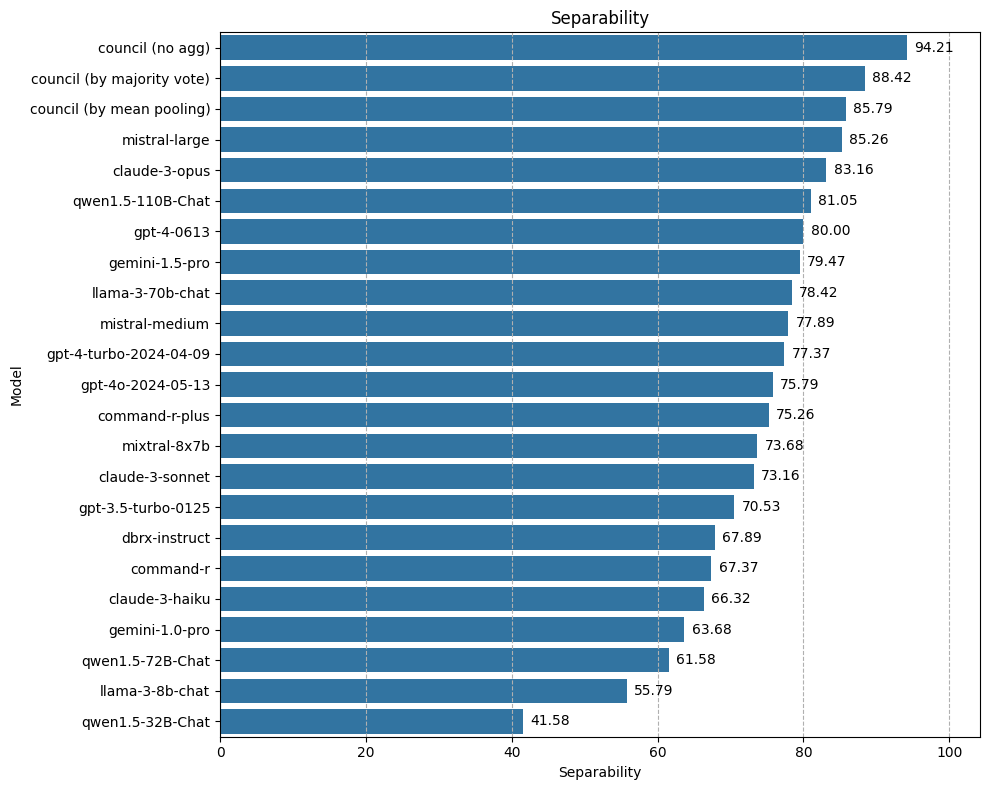

In [64]:
# Create the plot
plt.figure(figsize=(10, 8))

council_member_to_separability_df = council_member_to_separability_df.sort_values("separability", ascending=False)
ax = sns.barplot(
    data=council_member_to_separability_df,
    y=council_member_to_separability_df.index,
    x="separability",
)

for i, score in enumerate(council_member_to_separability_df["separability"]):
    plt.text(score + 1, i, f"{score:.2f}", va="center", color="black")

plt.xlabel("Separability")
plt.ylabel("Model")
plt.title("Separability")
plt.grid(axis="x", linestyle="--")
plt.xlim(right=council_member_to_separability_df["separability"].max() + 10)
plt.tight_layout()
plt.show()

# Affinity Analysis

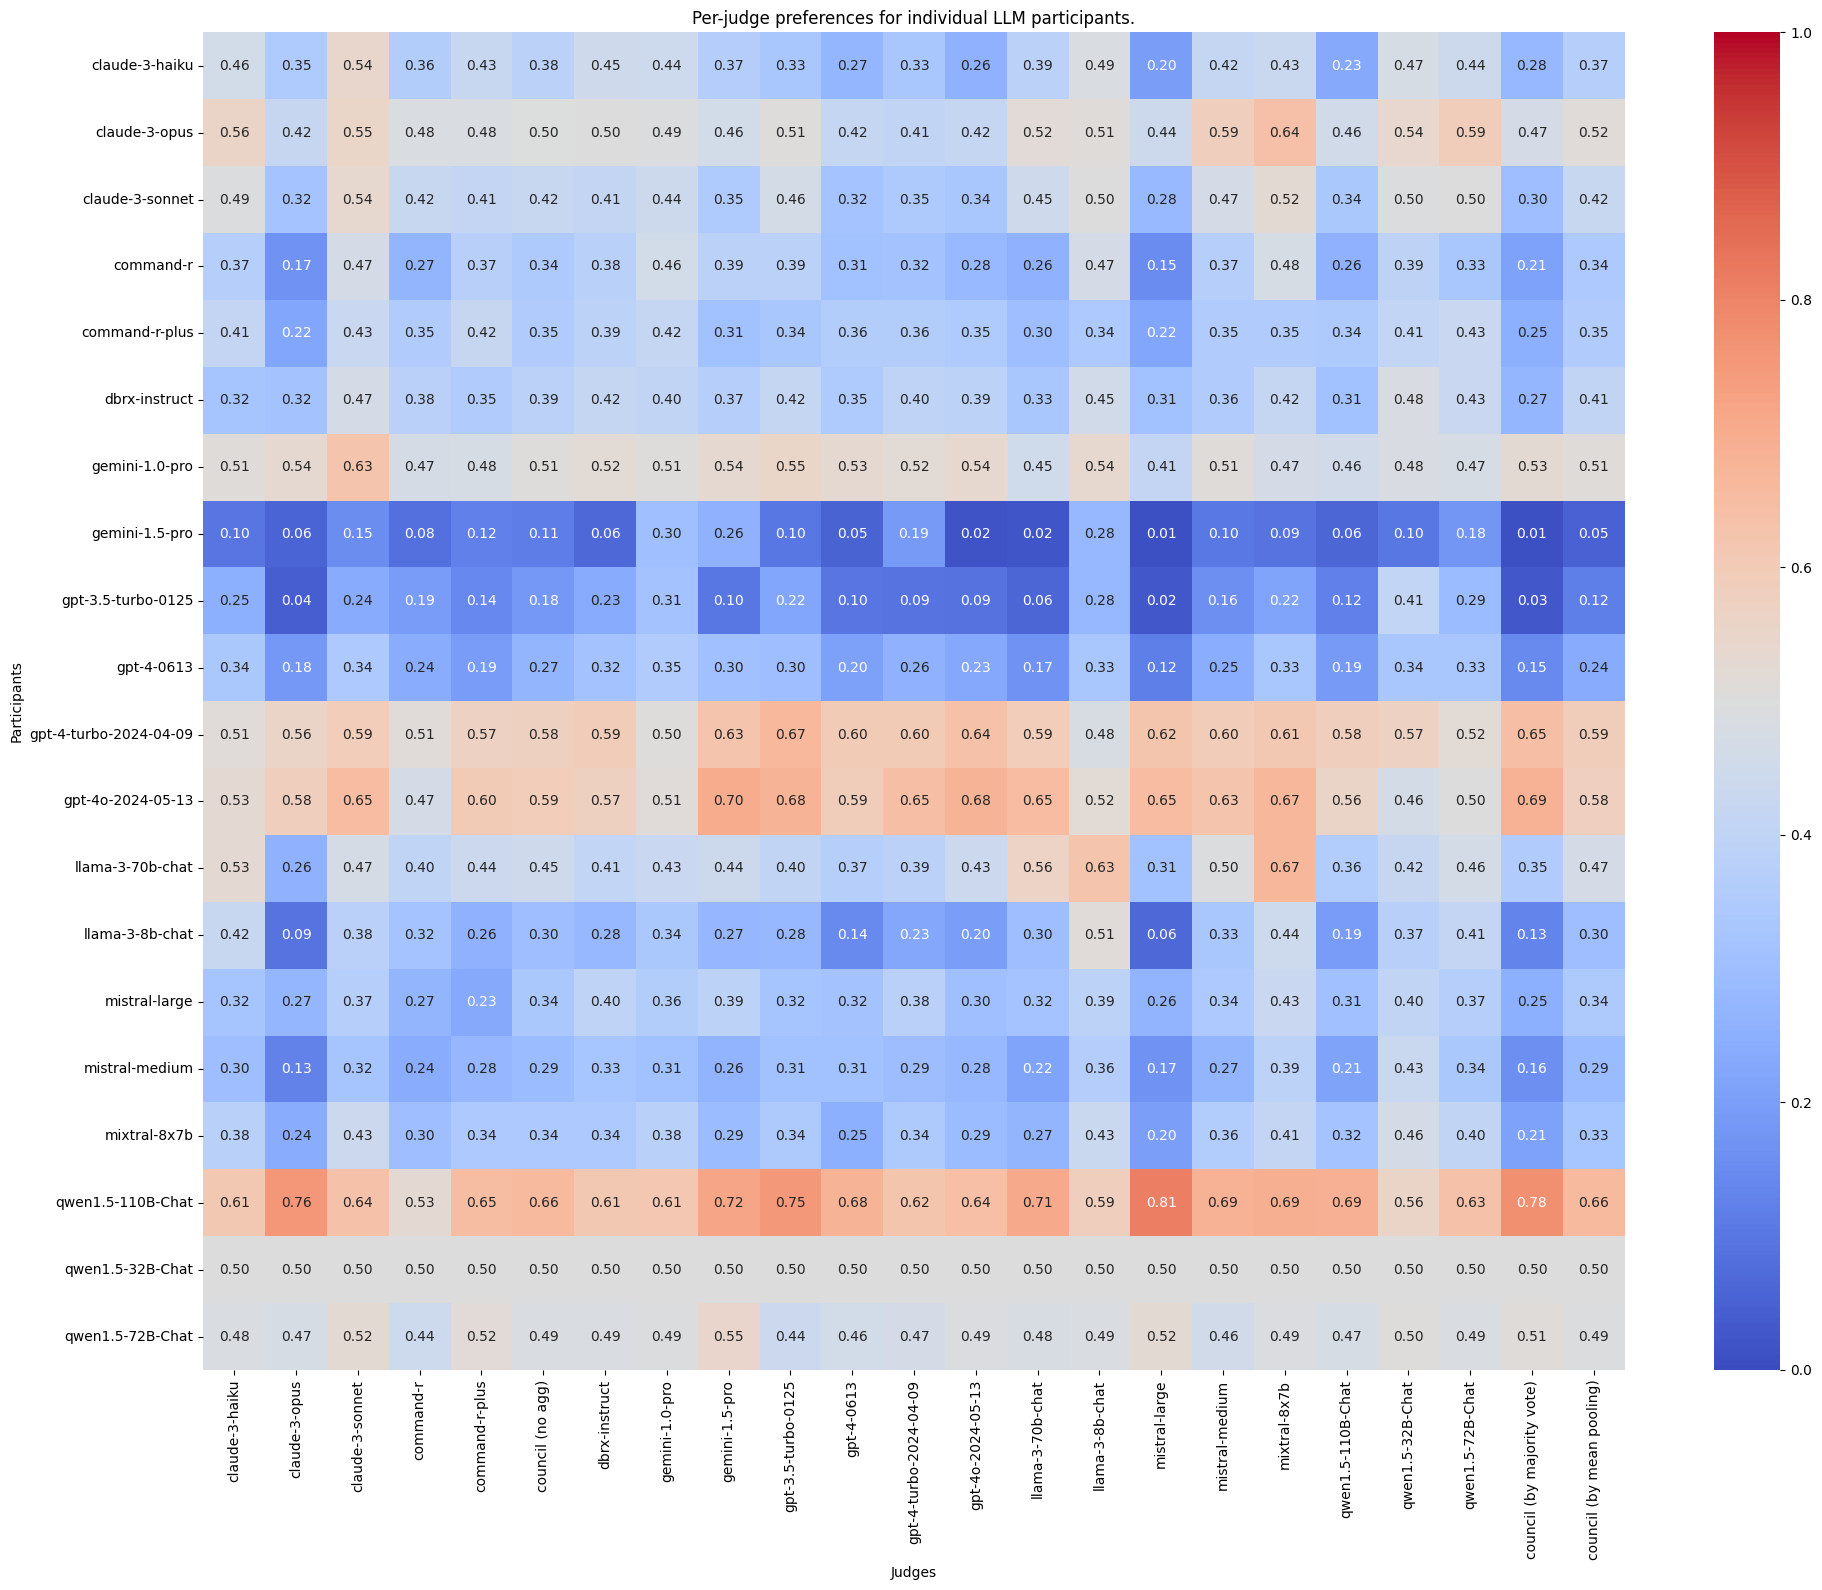

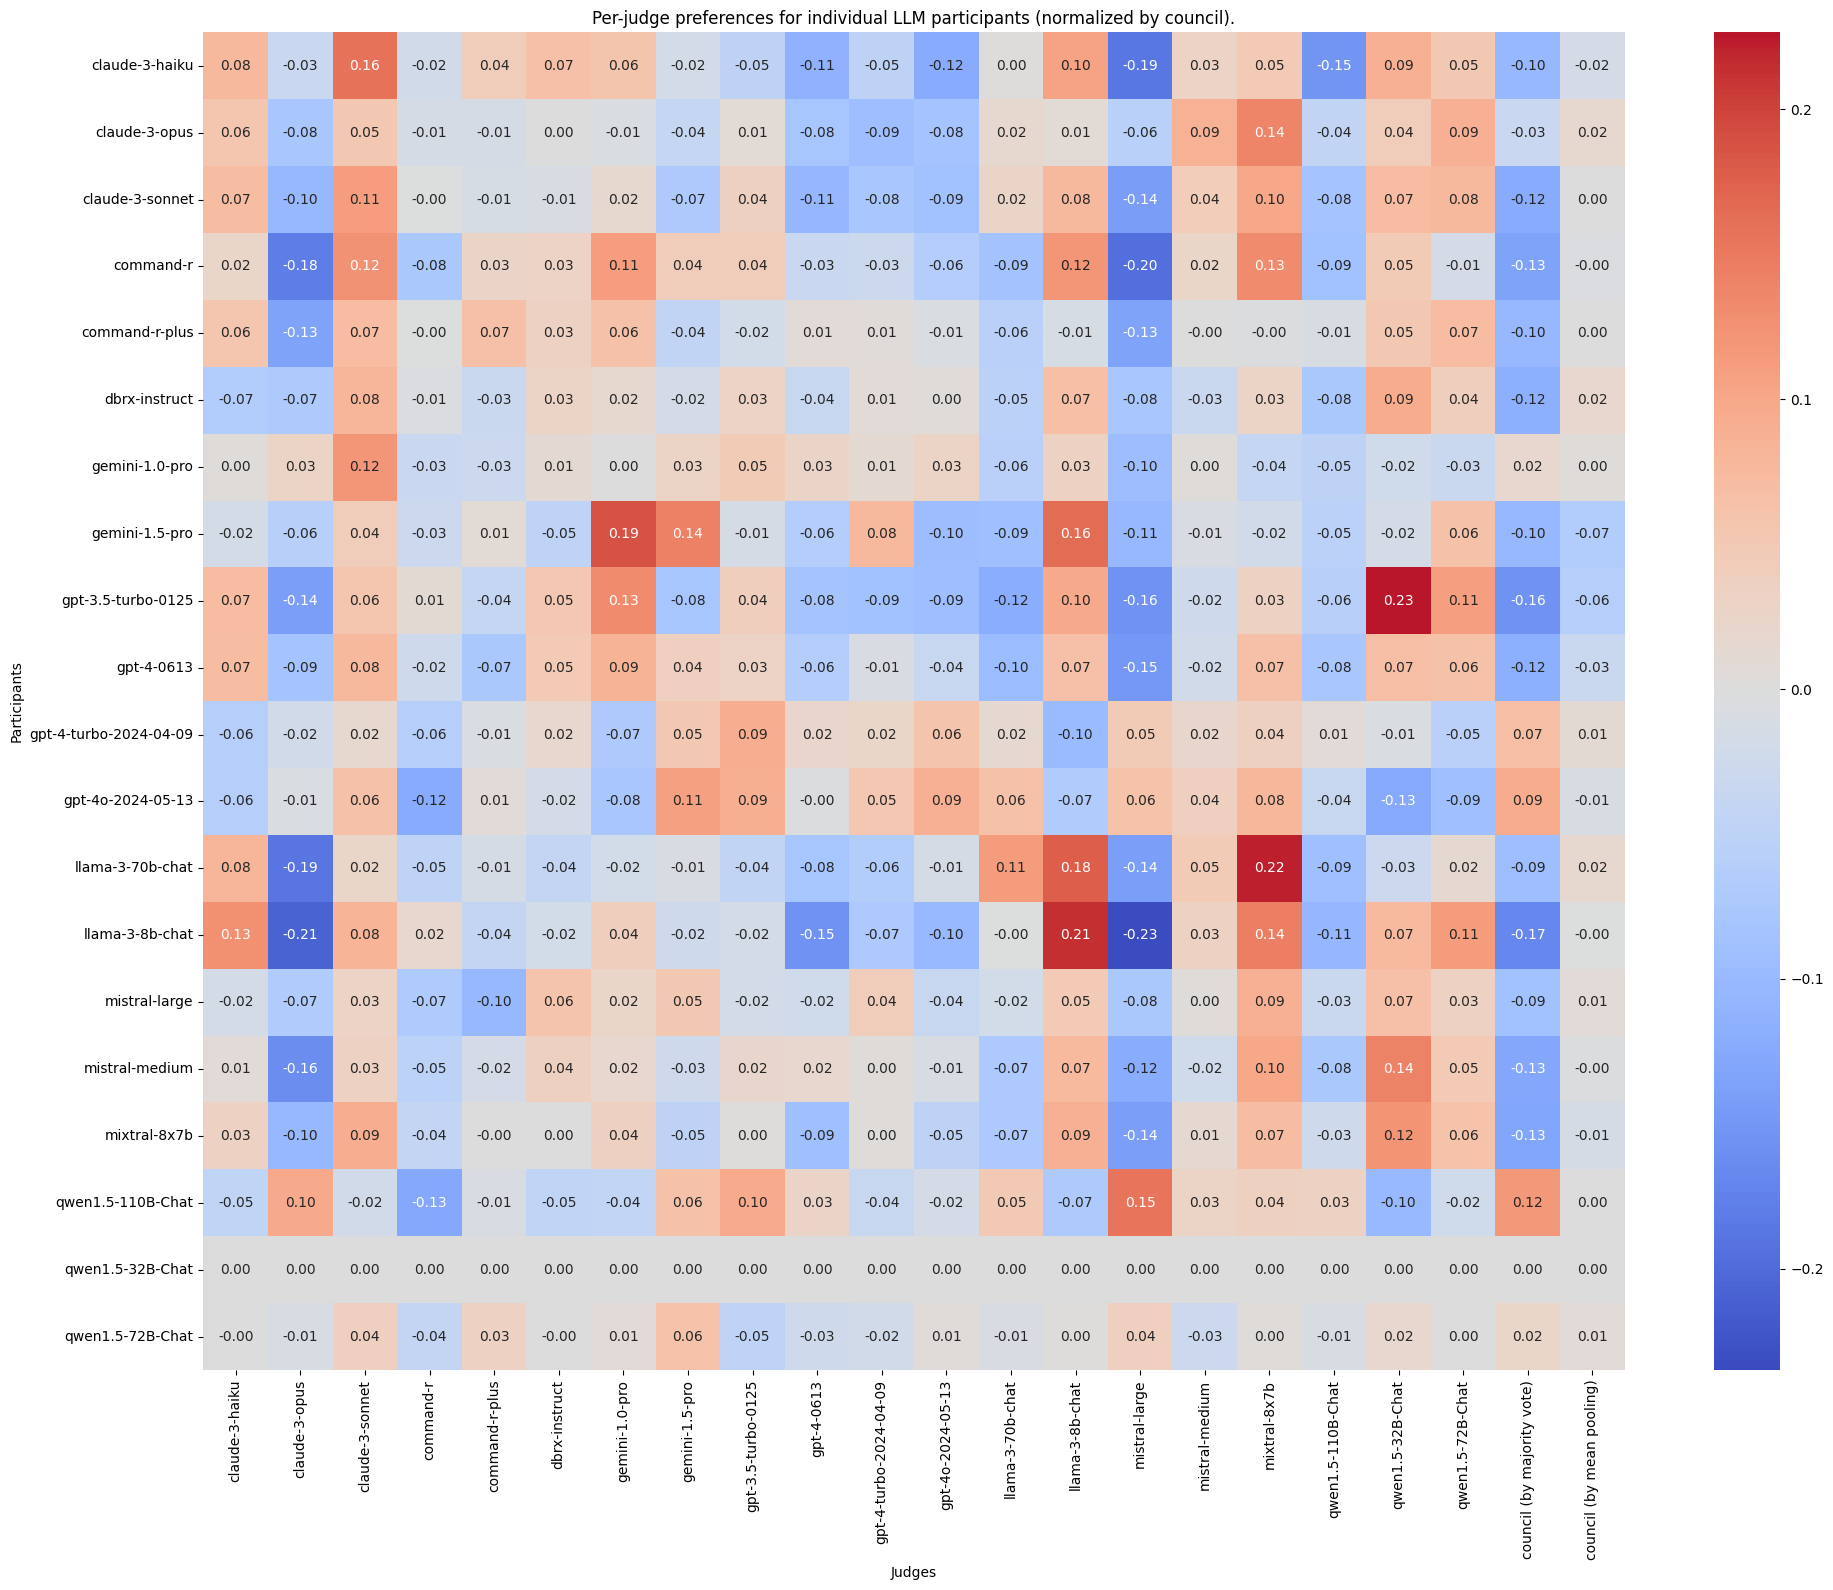

Self-enhancement bias
      command-r-plus  command-r  dbrx-instruct  qwen1.5-110B-Chat  \
bias           0.066    -0.0751         0.0301             0.0341   

      qwen1.5-72B-Chat  qwen1.5-32B-Chat  llama-3-70b-chat  llama-3-8b-chat  \
bias            0.0012               0.0            0.1147           0.2134   

      claude-3-opus  claude-3-sonnet  claude-3-haiku  gemini-1.5-pro  \
bias        -0.0791           0.1128          0.0768          0.1432   

      gemini-1.0-pro  mixtral-8x7b  mistral-medium  mistral-large  \
bias          0.0012         0.071         -0.0238        -0.0753   

      gpt-4o-2024-05-13  gpt-3.5-turbo-0125  gpt-4-0613  \
bias             0.0894              0.0405     -0.0632   

      gpt-4-turbo-2024-04-09  
bias                   0.024  


In [67]:
per_judge_preferences = {}
council_members = list(df["llm_judge"].unique())

for council_member in council_members:
    filtered_df = filter_ratings_by_allowlist(df, [council_member])

    # Single instance, no variation.
    bootstrap_online_elo = compute_mle_elo(filtered_df, reference_llm_completer)

    # Get win rates.
    win_rates = get_win_rate(bootstrap_online_elo, reference_llm_completer)

    per_judge_preferences[council_member] = win_rates

# Add the council.
council_choice = get_council_choice(df, "majority")
bootstrap_online_elo = compute_mle_elo(council_choice, reference_llm_completer)
win_rates = get_win_rate(bootstrap_online_elo, reference_llm_completer)
per_judge_preferences["council (by majority vote)"] = win_rates

council_choice = get_council_choice(df, "mean_pooling")
bootstrap_online_elo = compute_mle_elo(council_choice, reference_llm_completer)
win_rates = get_win_rate(bootstrap_online_elo, reference_llm_completer)
per_judge_preferences["council (by mean pooling)"] = win_rates

council_choice = df
bootstrap_online_elo = compute_mle_elo(council_choice, reference_llm_completer)
win_rates = get_win_rate(bootstrap_online_elo, reference_llm_completer)
per_judge_preferences["council (no agg)"] = win_rates

per_judge_preferences_df = pd.DataFrame(per_judge_preferences)
per_judge_preferences_df = per_judge_preferences_df / 100

plot_heatmap(
    sorted_dict_of_dict(per_judge_preferences_df.to_dict()),
    "Per-judge preferences for individual LLM participants.",
    ylabel="Participants",
    xlabel="Judges",
    vmin=0,
    vmax=1,
    cmap="coolwarm",
)

# Subtract out the council's win rate.
per_judge_preferences_council_normalized = defaultdict(dict)
for judge, participant_affinity in per_judge_preferences.items():
    if judge == "council (no agg)":
        continue
    for participant, affinity in participant_affinity.items():
        per_judge_preferences_council_normalized[judge][participant] = (
            affinity - per_judge_preferences["council (no agg)"][participant]
        )
per_judge_preferences_council_normalized_df = pd.DataFrame(
    per_judge_preferences_council_normalized
)
per_judge_preferences_council_normalized_df = (
    per_judge_preferences_council_normalized_df / 100
)

plot_heatmap(
    sorted_dict_of_dict(per_judge_preferences_council_normalized_df.to_dict()),
    "Per-judge preferences for individual LLM participants (normalized by council).",
    ylabel="Participants",
    xlabel="Judges",
    center=0,
    cmap="coolwarm",
)

# Self-enhancement bias.
print("Self-enhancement bias"
self_enhancement_bias = {}
for judge in council_members:
    if judge in per_judge_preferences_council_normalized[judge]:
        self_enhancement_bias[judge] = per_judge_preferences_council_normalized[
            judge
        ][judge]
self_enhancement_bias_df = pd.DataFrame(self_enhancement_bias, index=["bias"])
self_enhancement_bias_df = self_enhancement_bias_df / 100
print(self_enhancement_bias_df)

# Agreement analysis

In [76]:
from sklearn.metrics import cohen_kappa_score


def get_side(rating):
    if rating in {MINOR_A_WIN, MAJOR_A_WIN}:
        return "A"
    if rating in {MINOR_B_WIN, MAJOR_B_WIN}:
        return "B"
    return "Tie"



def get_judge_to_judge_agreement(judge1_votes, judge2_votes, method):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    # After removing inconsistent votes, it's possible that many votes are non-overlapping.
    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

    if not both_judge_vote_keys:
        return None

    # Extract the responses from both judges
    responses_judge1 = [judge1_votes[qid] for qid in both_judge_vote_keys]
    responses_judge2 = [judge2_votes[qid] for qid in both_judge_vote_keys]
    if method == "cohen_kappa":
        return cohen_kappa_score(
            responses_judge1,
            responses_judge2,
            labels=[MINOR_A_WIN, MINOR_B_WIN, MAJOR_A_WIN, MAJOR_B_WIN],
        )
    elif method == "exact":
        num_agreeements = 0
        for response_judge1, response_judge2 in zip(responses_judge1, responses_judge2):
            if response_judge1 == response_judge2:
                num_agreeements += 1
        return num_agreeements / len(responses_judge1)
    elif method == "sidewise":
        num_agreeements = 0
        for response_judge1, response_judge2 in zip(responses_judge1, responses_judge2):
            if (
                get_side(response_judge1) == get_side(response_judge2)
                or get_side(response_judge1) == "Tie"
                or get_side(response_judge2) == "Tie"
            ):
                # Count ties as agreement.
                num_agreeements += 1
        return num_agreeements / len(responses_judge1)
    elif method == "sidewise_cohen_kappa":
        return cohen_kappa_score(
            [get_side(response) for response in responses_judge1],
            [get_side(response) for response in responses_judge2],
            labels=["A", "B"],
        )
    else:
        raise ValueError(f"Unknown judge_to_judge_agreement method: {method}")


def plot_judge_agreement(df, agreement_method):
    judges = list(df["llm_judge"].unique())

    judge_to_votes_map = defaultdict(dict)
    for i, row in df.iterrows():
        judge_to_votes_map[row["llm_judge"]][
            (
                row["emobench_id"],
                row["first_completion_by"],
                row["second_completion_by"],
            )
        ] = row["pairwise_choice"]

    # Add the council.
    council_choice = get_council_choice(df, "majority")
    for i, row in council_choice.iterrows():
        judge_to_votes_map["council (by majority vote)"][
            (row["emobench_id"], row["first_completion_by"], row["second_completion_by"])
        ] = row["pairwise_choice"]
    council_choice = get_council_choice(df, "mean_pooling")
    for i, row in council_choice.iterrows():
        judge_to_votes_map["council (by mean pooling)"][
            (row["emobench_id"], row["first_completion_by"], row["second_completion_by"])
        ] = row["pairwise_choice"]

    # judge -> judge -> agreement (float)
    judge_to_judge_agreement = defaultdict(dict)
    for judge1 in judges + ["council (by majority vote)", "council (by mean pooling)"]:
        judge1_votes = judge_to_votes_map[judge1]

        for judge2 in judges + [
            "council (by majority vote)",
            "council (by mean pooling)",
        ]:
            if judge1 == judge2:
                continue
            judge2_votes = judge_to_votes_map[judge2]

            agreement = get_judge_to_judge_agreement(
                judge1_votes, judge2_votes, agreement_method
            )
            if agreement is not None:
                judge_to_judge_agreement[judge1][judge2] = agreement

    # Fix the LLM names.
    judge_to_judge_agreement = sorted_dict_of_dict(judge_to_judge_agreement)
    judge_to_judge_agreement_df = pd.DataFrame(judge_to_judge_agreement)

    # Plot
    if "cohen_kappa" in agreement_method or "sidewise_cohen_kappa" in agreement_method:
        vmin = -1
        vmax = 1
    else:
        vmin = 0
        vmax = 1

    plt.figure(figsize=(len(judges) + 4, len(judges) + 2))
    sns.heatmap(
        judge_to_judge_agreement_df,
        annot=judge_to_judge_agreement_df,
        cmap="coolwarm",
        fmt=".2f",
        vmin=vmin,
        vmax=vmax,
    )
    plt.title("Judge to Judge agreement")
    plt.setp(plt.xticks()[1], rotation=90)
    plt.ylabel("LLM Judges")
    plt.xlabel("LLM Judges")
    plt.tight_layout()
    plt.show()

    # Find the average agreement between two judges.
    agreements = []
    for judge, other_judge_agreement in judge_to_judge_agreement.items():
        for other_judge, agreement in other_judge_agreement.items():
            agreements.append(agreement)

    print(pd.DataFrame(agreements).mean())

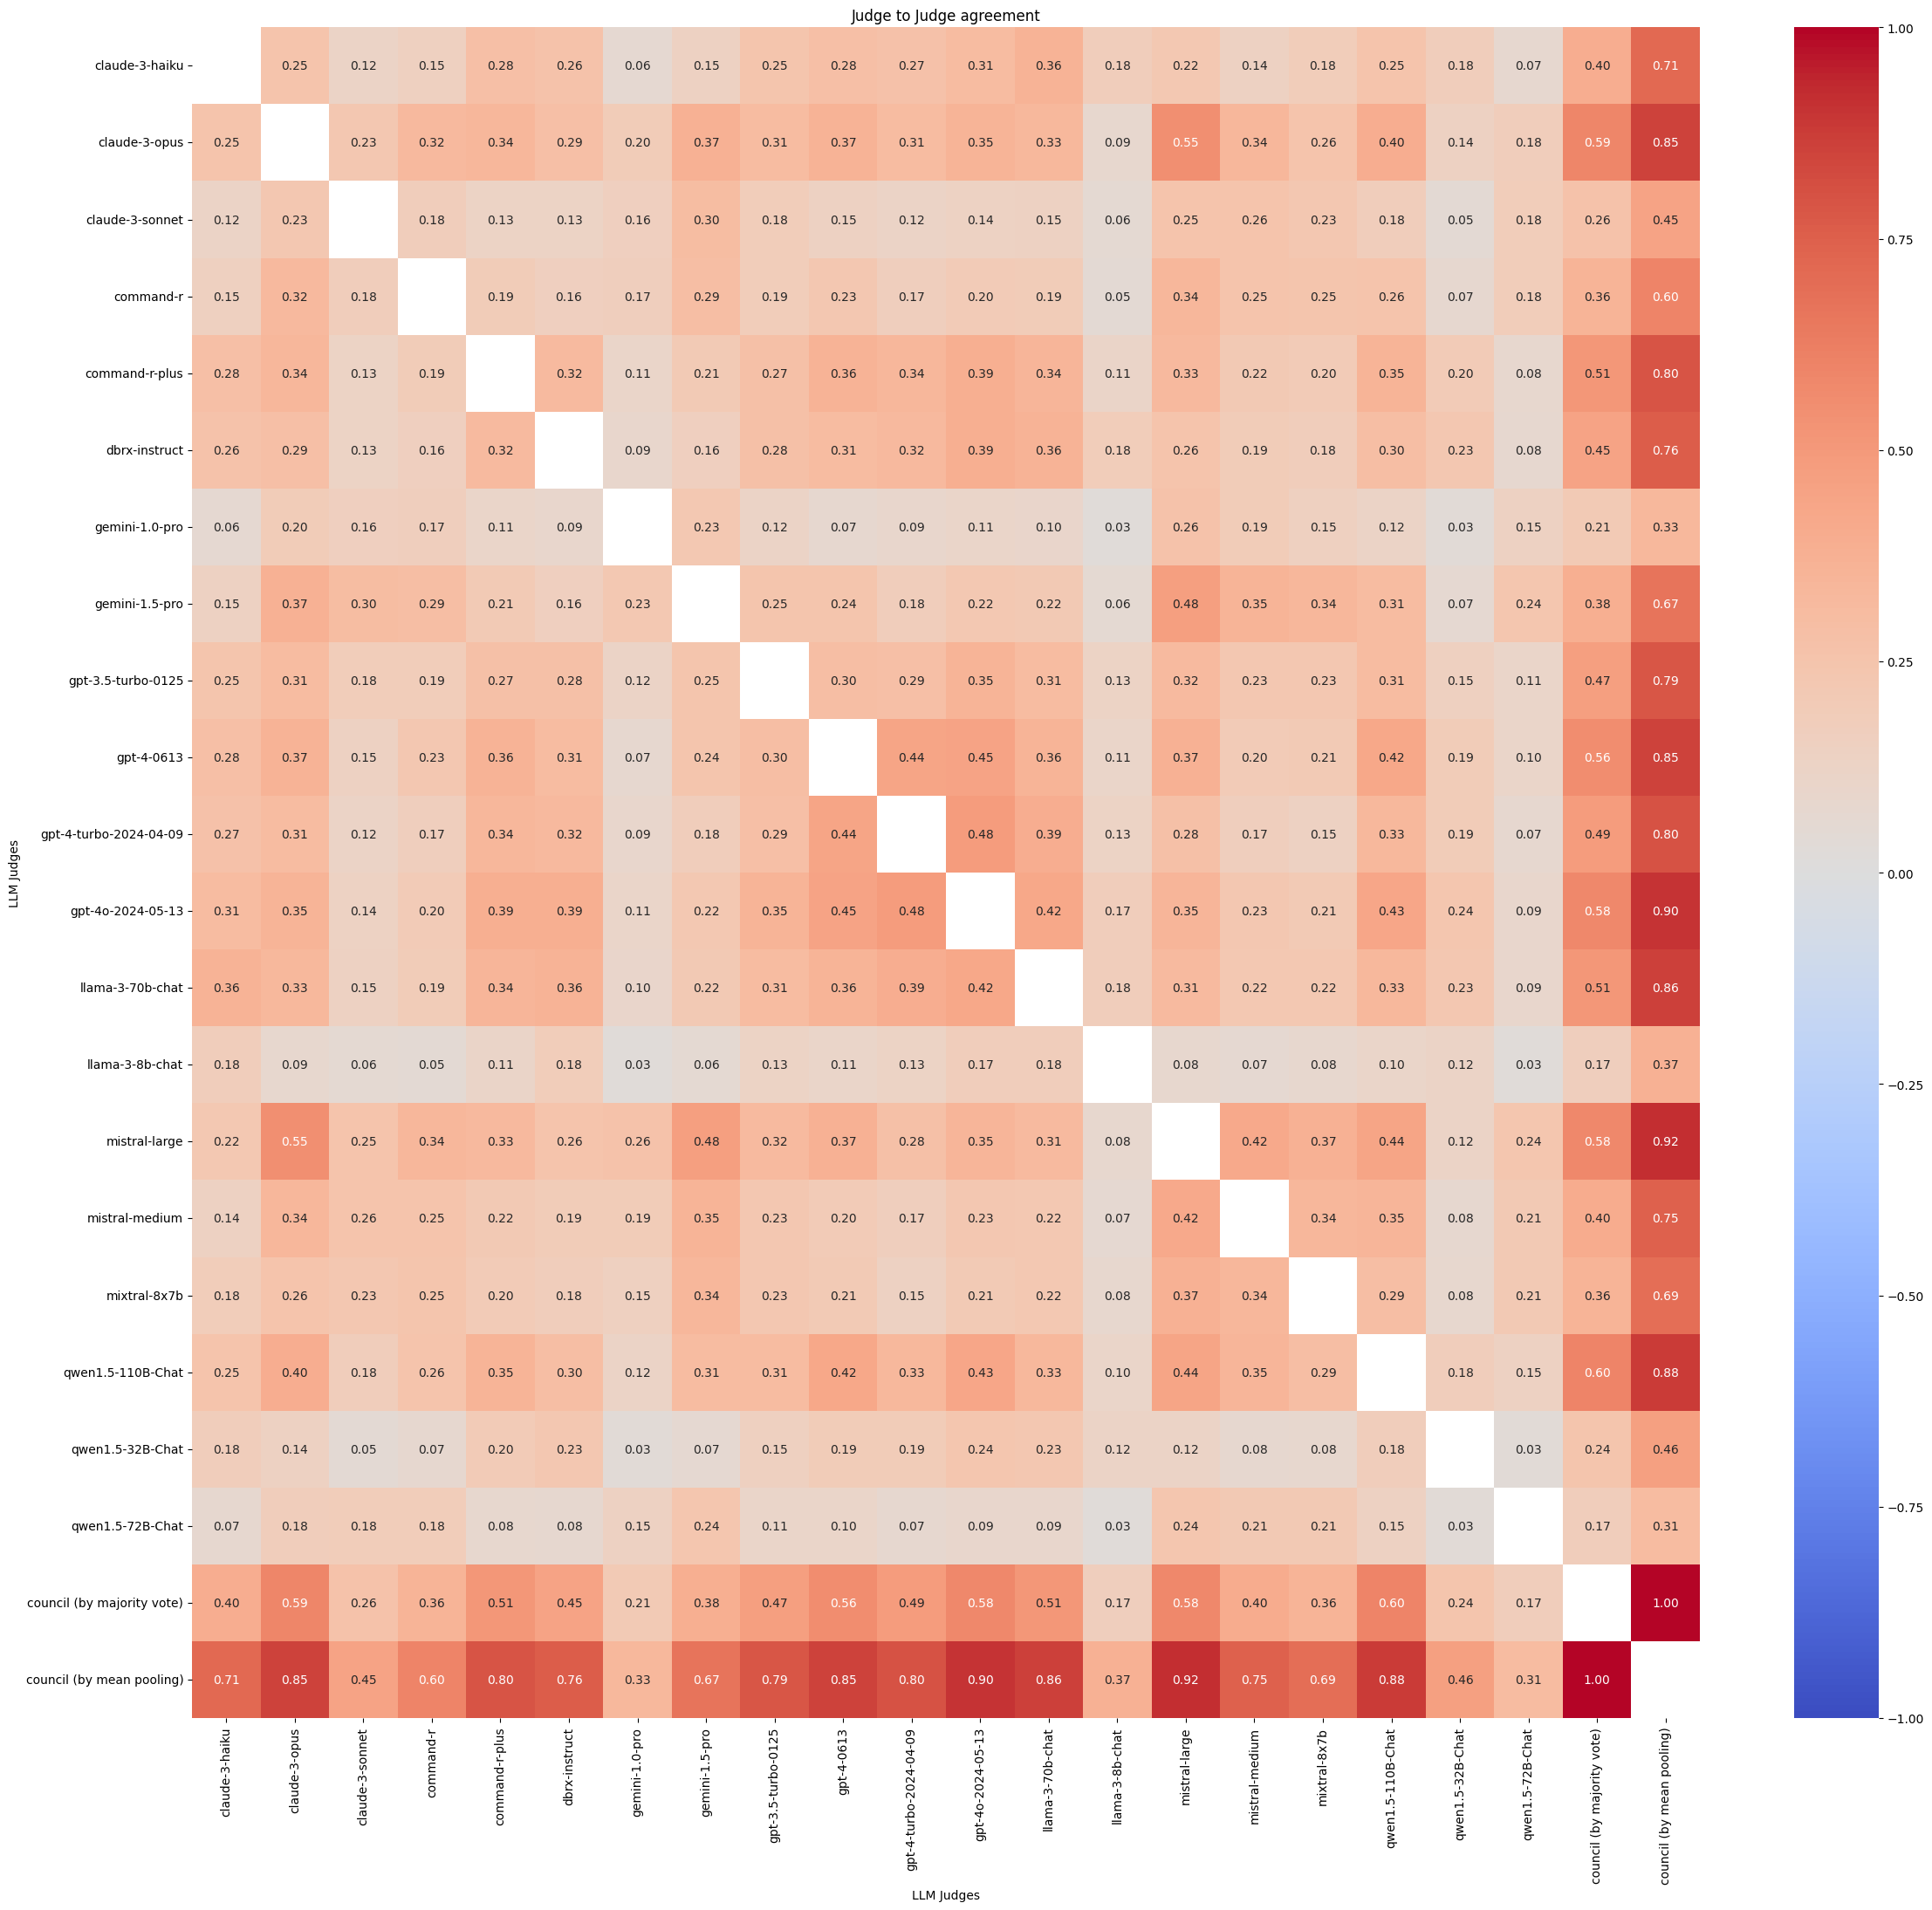

0    0.284229
dtype: float64


In [78]:
# plot_judge_agreement(df, "cohen_kappa")
# plot_judge_agreement(df, "exact")
# plot_judge_agreement(df, "sidewise")
plot_judge_agreement(df, "sidewise_cohen_kappa")

# Consistency and Invariability

In [82]:
def get_judge_consistency_df(full_judging_df):
    # Use the most common vote.
    df = (
        full_judging_df.groupby(
            ["emobench_id", "llm_judge", "first_completion_by", "second_completion_by"]
        )
        .agg(
            pairwise_choice=pd.NamedAgg(
                column="pairwise_choice", aggfunc=lambda x: x.mode()[0]
            ),
        )
        .reset_index()
    )

    judges = list(df["llm_judge"].unique())

    judge_to_votes_map = defaultdict(dict)
    for i, row in df.iterrows():
        judge_to_votes_map[row["llm_judge"]][
            (
                row["emobench_id"],
                row["first_completion_by"],
                row["second_completion_by"],
            )
        ] = row["pairwise_choice"]

    # Add the council.
    council_choice = get_council_choice(df, "majority")
    for i, row in council_choice.iterrows():
        judge_to_votes_map["council (by majority vote)"][
            (row["emobench_id"], row["first_completion_by"], row["second_completion_by"])
        ] = row["pairwise_choice"]

    council_choice = get_council_choice(df, "mean_pooling")
    for i, row in council_choice.iterrows():
        judge_to_votes_map["council (by mean pooling)"][
            (row["emobench_id"], row["first_completion_by"], row["second_completion_by"])
        ] = row["pairwise_choice"]

    for i, row in df.iterrows():
        judge_to_votes_map["council (no agg)"][
            (row["emobench_id"], row["first_completion_by"], row["second_completion_by"])
        ] = row["pairwise_choice"]

    # Measure consistency rates.
    judge_to_consistency_rate = {}
    judge_to_bias_towards_first_rate = {}
    judge_to_bias_towards_second_rate = {}
    judge_to_a_vote_rate = {}
    judge_to_b_vote_rate = {}
    judge_to_tie_vote_rate = {}
    judge_to_major_vote_rate = {}
    judge_to_major_a_vote_rate = {}
    judge_to_minor_a_vote_rate = {}
    judge_to_major_b_vote_rate = {}
    judge_to_minor_b_vote_rate = {}
    judge_to_consistent_a_vote_rate = {}
    judge_to_consistent_b_vote_rate = {}
    judge_to_consistent_tie_vote_rate = {}

    rating_to_value_map = {
        MAJOR_A_WIN: 2,
        MINOR_A_WIN: 1,
        TIE: 0,
        MINOR_B_WIN: -1,
        MAJOR_B_WIN: -2,
    }

    for judge, votes in judge_to_votes_map.items():
        judge_consistencies = 0
        judge_inconsistencies = 0
        bias_towards_first = 0
        bias_towards_second = 0

        total_a_votes = 0
        total_b_votes = 0
        total_tie_votes = 0
        total_major_a_votes = 0
        total_minor_a_votes = 0
        total_major_b_votes = 0
        total_minor_b_votes = 0
        total_major_votes = 0

        consistent_a_votes = 0
        consistent_b_votes = 0
        consistent_tie_votes = 0

        vote_keys = votes.keys()

        for vote_key in vote_keys:
            (id, first_completion_by, second_completion_by) = vote_key
            rating = votes[vote_key]
            reverse_rating_id = (id, second_completion_by, first_completion_by)
            if reverse_rating_id not in votes:
                # Skipping votes that don't have a reverse rating, which may happen during no-tie analysis.
                continue

            reverse_rating = votes[(id, second_completion_by, first_completion_by)]

            score_from_both_ratings = (
                rating_to_value_map[rating] + rating_to_value_map[reverse_rating]
            )

            # Consistencies.
            if rating == MAJOR_A_WIN and reverse_rating == MAJOR_B_WIN:
                consistent_a_votes += 1
                judge_consistencies += 1
            if rating == MAJOR_A_WIN and reverse_rating == MINOR_B_WIN:
                consistent_a_votes += 1
                judge_consistencies += 1
            if rating == MINOR_A_WIN and reverse_rating == MAJOR_B_WIN:
                consistent_a_votes += 1
                judge_consistencies += 1
            if rating == MINOR_A_WIN and reverse_rating == MINOR_B_WIN:
                consistent_a_votes += 1
                judge_consistencies += 1
            if rating == MAJOR_B_WIN and reverse_rating == MAJOR_A_WIN:
                consistent_b_votes += 1
                judge_consistencies += 1
            if rating == MAJOR_B_WIN and reverse_rating == MINOR_A_WIN:
                consistent_b_votes += 1
                judge_consistencies += 1
            if rating == MINOR_B_WIN and reverse_rating == MAJOR_A_WIN:
                consistent_b_votes += 1
                judge_consistencies += 1
            if rating == MINOR_B_WIN and reverse_rating == MINOR_A_WIN:
                consistent_b_votes += 1
                judge_consistencies += 1

            # Consistent ties.
            if rating == TIE and reverse_rating == TIE:
                consistent_tie_votes += 1
                judge_consistencies += 1

            # Inconsistencies.
            if rating == MAJOR_A_WIN and reverse_rating == MAJOR_A_WIN:
                judge_inconsistencies += 1
                bias_towards_first += 1
            if rating == MAJOR_A_WIN and reverse_rating == MINOR_A_WIN:
                judge_inconsistencies += 1
                bias_towards_first += 1
            if rating == MINOR_A_WIN and reverse_rating == MAJOR_A_WIN:
                judge_inconsistencies += 1
                bias_towards_first += 1
            if rating == MINOR_A_WIN and reverse_rating == MINOR_A_WIN:
                judge_inconsistencies += 1
                bias_towards_first += 1
            if rating == MAJOR_A_WIN and reverse_rating == TIE:
                judge_inconsistencies += 1
                bias_towards_first += 1
            if rating == MINOR_A_WIN and reverse_rating == TIE:
                judge_inconsistencies += 1
                bias_towards_first += 1
            if rating == MAJOR_B_WIN and reverse_rating == MAJOR_B_WIN:
                judge_inconsistencies += 1
                bias_towards_second += 1
            if rating == MAJOR_B_WIN and reverse_rating == MINOR_B_WIN:
                judge_inconsistencies += 1
                bias_towards_second += 1
            if rating == MINOR_B_WIN and reverse_rating == MAJOR_B_WIN:
                judge_inconsistencies += 1
                bias_towards_second += 1
            if rating == MINOR_B_WIN and reverse_rating == MINOR_B_WIN:
                judge_inconsistencies += 1
                bias_towards_second += 1
            if rating == MAJOR_B_WIN and reverse_rating == TIE:
                judge_inconsistencies += 1
                bias_towards_second += 1
            if rating == MINOR_B_WIN and reverse_rating == TIE:
                judge_inconsistencies += 1
                bias_towards_second += 1

            # Tie inconsistencies.
            if rating == TIE and reverse_rating in {MINOR_A_WIN, MAJOR_A_WIN}:
                judge_inconsistencies += 1
                bias_towards_first += 1
            if rating == TIE and reverse_rating in {MINOR_B_WIN, MAJOR_B_WIN}:
                judge_inconsistencies += 1
                bias_towards_second += 1

            # Total A or B votes.
            if rating in {MAJOR_A_WIN, MAJOR_B_WIN}:
                total_major_votes += 1
            if rating in {MINOR_A_WIN, MAJOR_A_WIN}:
                total_a_votes += 1
            elif rating in {MINOR_B_WIN, MAJOR_B_WIN}:
                total_b_votes += 1
            else:
                total_tie_votes += 1

            # Granular A/B votes
            if rating == MAJOR_A_WIN:
                total_major_a_votes += 1
            if rating == MINOR_A_WIN:
                total_minor_a_votes += 1
            if rating == MINOR_B_WIN:
                total_minor_b_votes += 1
            if rating == MAJOR_B_WIN:
                total_major_b_votes += 1

        judge_to_consistency_rate[judge] = judge_consistencies / len(
            votes
        )
        judge_to_bias_towards_first_rate[judge] = bias_towards_first / len(votes)
        judge_to_bias_towards_second_rate[judge] = bias_towards_second / len(votes)

        judge_to_a_vote_rate[judge] = total_a_votes / len(votes)
        judge_to_b_vote_rate[judge] = total_b_votes / len(votes)
        judge_to_major_vote_rate[judge] = total_major_votes / len(votes)
        judge_to_major_a_vote_rate[judge] = total_major_a_votes / len(votes)
        judge_to_minor_a_vote_rate[judge] = total_minor_a_votes / len(votes)
        judge_to_major_b_vote_rate[judge] = total_major_b_votes / len(votes)
        judge_to_minor_b_vote_rate[judge] = total_minor_b_votes / len(votes)
        judge_to_tie_vote_rate[judge] = total_tie_votes / len(votes)
        judge_to_consistent_a_vote_rate[judge] = (
            consistent_a_votes / len(votes)
        )
        judge_to_consistent_b_vote_rate[judge] = (
            consistent_b_votes / len(votes)
        )
        judge_to_consistent_tie_vote_rate[judge] = (
            consistent_tie_votes / len(votes)
        )

    # Save the inconsistent / consistency rates.
    judge_to_consistency_df = pd.DataFrame(
        {
            "consistency_rate": judge_to_consistency_rate,
            "bias_toward_first": judge_to_bias_towards_first_rate,
            "bias_toward_second": judge_to_bias_towards_second_rate,
            "a_vote_rate": judge_to_a_vote_rate,
            "b_vote_rate": judge_to_b_vote_rate,
            "tie_vote_rate": judge_to_tie_vote_rate,
            "major_vote_rate": judge_to_major_vote_rate,
            "major_a_vote_rate": judge_to_major_a_vote_rate,
            "minor_a_vote_rate": judge_to_minor_a_vote_rate,
            "major_b_vote_rate": judge_to_major_b_vote_rate,
            "minor_b_vote_rate": judge_to_minor_b_vote_rate,
            "consistent_a_vote_rate": judge_to_consistent_a_vote_rate,
            "consistent_b_vote_rate": judge_to_consistent_b_vote_rate,
            "consistent_tie_vote_rate": judge_to_consistent_tie_vote_rate,
        }
    )
    return judge_to_consistency_df


def get_judge_consistency_pairwise_df(full_judging_df):
    x = (
        full_judging_df.groupby(
            ["emobench_id", "llm_judge", "first_completion_by", "second_completion_by"]
        )
        .agg(
            pairwise_choice=pd.NamedAgg(column="pairwise_choice", aggfunc=list),
        )
        .reset_index()
    )

    judge_to_votes_map = defaultdict(dict)
    for i, row in x.iterrows():
        judge_to_votes_map[row["llm_judge"]][
            (
                row["emobench_id"],
                row["first_completion_by"],
                row["second_completion_by"],
            )
        ] = row["pairwise_choice"]

    import numpy as np

    # judge_to_votes_map
    def is_consistent(rating_tuple):
        rating, reverse_rating = rating_tuple
        # Consistencies.
        if rating in {MAJOR_A_WIN, MINOR_A_WIN} and reverse_rating in {
            MAJOR_B_WIN,
            MINOR_B_WIN,
        }:
            return 1
        if rating in {MAJOR_B_WIN, MINOR_B_WIN} and reverse_rating in {
            MAJOR_A_WIN,
            MINOR_A_WIN,
        }:
            return 1
        if reverse_rating in {MAJOR_A_WIN, MINOR_A_WIN} and rating in {
            MAJOR_B_WIN,
            MINOR_B_WIN,
        }:
            return 1
        if reverse_rating in {MAJOR_B_WIN, MINOR_B_WIN} and rating in {
            MAJOR_A_WIN,
            MINOR_A_WIN,
        }:
            return 1
        if reverse_rating in {TIE} and rating in {TIE}:
            return 1
        if reverse_rating in {TIE} and rating not in {TIE}:
            return 0
        if rating in {TIE} and reverse_rating not in {TIE}:
            return 0
        return 0

    judge_to_list_of_consistencies = defaultdict(list)
    for judge, votes in judge_to_votes_map.items():
        vote_keys = votes.keys()

        consistencies_for_vote_key = []
        for vote_key in vote_keys:
            (id, first_completion_by, second_completion_by) = vote_key
            ratings = votes[vote_key]
            reverse_rating_id = (id, second_completion_by, first_completion_by)

            if reverse_rating_id not in votes:
                # Skipping votes that don't have a reverse rating, which may happen during no-tie analysis.
                continue

            reverse_ratings = votes[(id, second_completion_by, first_completion_by)]

            couplets = [(x, y) for x in ratings for y in reverse_ratings]

            consistent_couplet_counter = 0
            for couplet in couplets:
                consistent_couplet_counter += is_consistent(couplet)
            consistencies_for_vote_key.append(
                consistent_couplet_counter / len(couplets)
            )

        judge_to_list_of_consistencies[judge].append(
            np.mean(consistencies_for_vote_key)
        )

    return judge_to_list_of_consistencies

In [83]:
judge_to_consistency_df = get_judge_consistency_df(df)

judge_to_list_of_consistencies = get_judge_consistency_pairwise_df(df)
x = pd.DataFrame(judge_to_list_of_consistencies).T

x.columns = ["multirep_consistency"]
judge_to_consistency_df = judge_to_consistency_df.merge(
    x, left_index=True, right_index=True
)
judge_to_consistency_df["multirep_consistency"] = judge_to_consistency_df[
    "multirep_consistency"
]

judge_to_consistency_df

,consistency_rate,bias_toward_first,bias_toward_second,a_vote_rate,b_vote_rate,tie_vote_rate,major_vote_rate,major_a_vote_rate,minor_a_vote_rate,major_b_vote_rate,minor_b_vote_rate,consistent_a_vote_rate,consistent_b_vote_rate,consistent_tie_vote_rate,multirep_consistency
claude-3-haiku,0.442632,0.520000,0.037368,0.741316,0.258684,0.000000,0.008684,0.006842,0.734474,0.001842,0.256842,0.221316,0.221316,0.0,0.442632
claude-3-opus,0.747895,0.090000,0.162105,0.463947,0.536053,0.000000,0.000789,0.000263,0.463684,0.000526,0.535526,0.373947,0.373947,0.0,0.747895
claude-3-sonnet,0.398947,0.038947,0.562105,0.238421,0.761579,0.000000,0.053684,0.023421,0.215000,0.030263,0.731316,0.199474,0.199474,0.0,0.398947
command-r,0.543158,0.073158,0.383684,0.344211,0.653684,0.002105,0.197368,0.009211,0.335000,0.188158,0.465526,0.271579,0.271579,0.0,0.543158
command-r-plus,0.528947,0.450526,0.020526,0.714737,0.284737,0.000526,0.009474,0.001579,0.713158,0.007895,0.276842,0.264474,0.264474,0.0,0.528947
dbrx-instruct,0.453684,0.517895,0.028421,0.744474,0.255000,0.000526,0.010526,0.008421,0.736053,0.002105,0.252895,0.226842,0.226842,0.0,0.453684
gemini-1.0-pro,0.349474,0.043684,0.606842,0.217632,0.776842,0.005526,0.023421,0.006053,0.211579,0.017368,0.759474,0.174737,0.174737,0.0,0.349474
gemini-1.5-pro,0.525789,0.014211,0.460000,0.277105,0.722632,0.000263,0.006316,0.000526,0.276579,0.005789,0.716842,0.262895,0.262895,0.0,0.525789
gpt-3.5-turbo-0125,0.577368,0.326842,0.095789,0.615000,0.384211,0.000789,0.174737,0.130789,0.484211,0.043947,0.340263,0.288684,0.288684,0.0,0.577368
gpt-4-0613,0.556842,0.371053,0.072105,0.646316,0.345789,0.007895,0.014737,0.007368,0.638947,0.007368,0.338421,0.278421,0.278421,0.0,0.556842


# Length bias

In [85]:
# Build LLM to token counts df.
dataset_responses = load_dataset("llm-council/emotional_application", "response_collection")
dataset_responses_df = dataset_responses["council"].to_pandas()

Generating council split: 100%|██████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 150314.62 examples/s]


In [86]:
dataset_responses_df

,emobench_id,problem,relationship,scenario,detailed_dilemma,response_string,llm_responder
0,119,Self,Personal,"Leah had a big fight with her best friend, and...","Two weeks ago, I had a huge fall-out with my b...",It's clear that you value this friendship and ...,command-r-plus
1,18,Interpersonal,Personal,Bella is overseas when she finds out that her ...,I was abroad when I received the news of my fa...,I'm so sorry for your loss. Losing a parent is...,command-r-plus
2,92,Interpersonal,Social,One of Erin's classmates is thought to be extr...,Here is the expanded interpersonal conflict fo...,It's great that Alex felt comfortable enough t...,command-r-plus
3,13,Interpersonal,Personal,Katerina takes a long time to turn on putting ...,"I'm Katerina, and I love spending family movie...","Katerina, it's completely understandable that ...",command-r-plus
4,88,Interpersonal,Social,"At a company meeting, Sally got into an argume...",Here is a 300-word story expanding on the inte...,It's completely valid to feel annoyed and slig...,command-r-plus
...,...,...,...,...,...,...,...
3995,110,Self,Personal,Jenny's sister has been borrowing money from h...,"I've always been close to my younger sister, E...",I understand how challenging this situation mu...,gpt-4-turbo-2024-04-09
3996,25,Interpersonal,Personal,Eileen has been diagnosed with a terminal dise...,The silence that followed the crash of my phon...,I'm truly sorry to hear about the emotional an...,gpt-4-turbo-2024-04-09
3997,197,Self,Social,Frank and his team gave the proposal presentat...,"As the team leader, I was proud of the proposa...",It's important to address concerns about feedb...,gpt-4-turbo-2024-04-09
3998,124,Self,Personal,"After a very tough breakup, Nathan is struggli...","After the breakup, the silence was deafening. ...",I'm truly sorry to hear about your struggles. ...,gpt-4-turbo-2024-04-09


In [92]:
# Find the average response lengths for each LLM.

def get_num_words(text):
    return len(text.split())
    

completer_to_num_words = defaultdict(list)
for i, row in dataset_responses_df.iterrows():
    num_words = get_num_words(row["response_string"])
    completer_to_num_words[row["llm_responder"]].append(num_words)


completer_to_num_words = pd.DataFrame(completer_to_num_words)
completer_token_counts_profile = completer_token_counts.describe().T

In [93]:
completer_token_counts_profile

,count,mean,std,min,25%,50%,75%,max
command-r-plus,200.0,222.085,16.798773,178.0,210.00,224.0,235.25,249.0
command-r,200.0,227.825,15.298516,185.0,218.00,231.5,240.25,250.0
dbrx-instruct,200.0,233.805,13.196885,174.0,228.00,237.0,243.25,250.0
qwen1.5-110B-Chat,200.0,233.350,17.950448,118.0,229.00,239.0,245.00,250.0
qwen1.5-72B-Chat,200.0,236.805,11.597391,179.0,231.75,239.0,245.00,250.0
qwen1.5-32B-Chat,200.0,236.955,11.110816,191.0,232.00,240.0,245.00,250.0
llama-3-70b-chat,200.0,224.630,15.959216,157.0,215.00,228.0,237.00,250.0
llama-3-8b-chat,200.0,207.930,20.381662,112.0,197.75,208.5,220.00,250.0
claude-3-opus,200.0,228.245,14.081064,188.0,217.75,229.5,240.00,250.0
claude-3-sonnet,200.0,226.710,13.963553,188.0,219.00,228.0,236.25,250.0


In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def get_length_bias(stats_df):
    stats_df = stats_df.merge(completer_token_counts_profile["mean"], left_on="model", right_index=True)
    stats_df = stats_df.rename(columns={"mean": "num_words"})
    
    # Separate the independent and dependent variables
    X = stats_df[['num_words']]
    y = stats_df['score']
    
    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the scores
    y_pred = model.predict(X)
    
    # Calculate the R-Squared value
    r_squared = r2_score(y, y_pred)
    return r_squared


for llm_judge, stats_df in council_member_to_rankings.items():
    print(llm_judge) 
    print(f"{get_length_bias(stats_df):.3f}")

council (no agg)
0.542
council (by majority vote)
0.368
council (by mean pooling)
0.594
command-r-plus
0.547
command-r
0.624
dbrx-instruct
0.625
qwen1.5-110B-Chat
0.437
qwen1.5-72B-Chat
0.603
qwen1.5-32B-Chat
0.754
llama-3-70b-chat
0.496
llama-3-8b-chat
0.513
claude-3-opus
0.364
claude-3-sonnet
0.657
claude-3-haiku
0.621
gemini-1.5-pro
0.259
gemini-1.0-pro
0.472
mixtral-8x7b
0.527
mistral-medium
0.532
mistral-large
0.327
gpt-4o-2024-05-13
0.442
gpt-3.5-turbo-0125
0.417
gpt-4-0613
0.409
gpt-4-turbo-2024-04-09
0.352
